# Спортивный анализ данных. Платформа Kaggle

## Курсовой проект

### Импортируем библиотеки

In [1]:
# !pip install tabulate
# !pip install catboost

In [2]:
from typing import List, Optional
from tqdm import tqdm

from IPython.display import HTML, display, Markdown
from tabulate import tabulate

import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp, shapiro, mannwhitneyu, chi2_contingency

import catboost as cb
import xgboost as xgb
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
%matplotlib inline

pd.set_option("display.max_columns", 600)
pd.set_option("display.max_rows", 600)

### Пользовательские функции

In [3]:
# Значения по умолчанию.

# Путь к папке сданными.
base_path = 'geekbrains-competitive-data-analysis'
# Первичный ключ.
primary_key = 'table_id'
# Размер классификатора.
directory_size = 25
# Параметры кроссвалидации.
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42
}
# Параметры подбора гиперпараметров.
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500], 'max_depth':[3, 5, 7]}
scoring='f1'
n_jobs=-1
# Количество фолдов.
k_fold_n_splits=5
# Выбираем вариант обучения (kfold, logistic, kn, xgb, lgbm, catboost, best, ensemble).  По умолчанию задано kfold.
model_is = 'kfold'
# Заместитель пустого значения в номинативном классификаторе.
empty_value = 'XNA'
# Коэффициент выброса колонки.
cutoff_factor = 0.9
# Величина допустимой погрешности.
significance=0.01
# Целевая колонка.
target_field_name = 'target'
# Отсечка по значению корелляции.
correlation_cutoff = 0.99
# Способ заполнения пустых значений: 'mode' — мода 'median' — медиана 'regression' — регрессия.
filling_empty_values = 'median'
# Перцентили отсечения выбросов
lower_percentile = 1
upper_percentile = 99
# Параметры отбора показателей.
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "nthread": 6,
    "seed": 27
}
xgb_num_boost_round = 500
xgb_early_stopping_rounds = 20
xgb_verbose_eval = 10
cutter_permutation_importance = 10.0e-05
# Шаг отсечки калибровки данных.
threshold_step = 0.001

# Делать обзор данных
is_show_table_info = True
# Делать обзор основных переменных.
is_data_overview = True
# Обрабатывать пропуски.
is_processing_passes = True
# Обрабатывать выбросы.
is_clear_outlier = True
# Проводить корреляционный анализ.
is_correlation_overview = True
# Разложить классификаторы в dummies.
is_build_nominative_dummies = True
is_build_numerical_dummies = True
# Стандартизировать данные.
is_standardize = True
# Произвести отбор признаков.
is_feature_selection = True
# Калибровать итоговое значение.
calibrate = False

# Названия колонок в сохраняемом результате.
column_id_name = 'APPLICATION_NUMBER'
column_target_name = 'TARGET'

Переопределяем некоторые значения настроек для достижения наилучших результатов.

In [4]:
# Обрабатывать пропуски.
is_processing_passes = False
# Обрабатывать выбросы.
is_clear_outlier = False

_Загрузка данных_

In [5]:
def load(filename):
    """
    Загрузить табличные данные из файла csv.
    :param filename: имя файла.
    :return: загруженный набор данных
    """

    data = pd.read_csv(f"{base_path}/{filename}")
    data.columns = [column.lower() for column in data.columns]
    print(f"{filename}: shape = {data.shape[0]} rows, {data.shape[1]} columns")
    return data

In [6]:
def nominative_to_numerical(data, shared):
    """
    Разложить номинативные признаки в числовые.
    :param data: исходный набор данных.
    :param shared: общие с другими таблицами колонки.
    :return: преобразованный набор данных.
    """

    columns = list(set(data.select_dtypes(include='object').columns.values) - set([primary_key]) - set(shared))
    for column in columns:

        # Заполнили пропуски
        if len(data[column]) - data[column].count() > 0:
            data.loc[data[column].isnull(), column] = empty_value

        # Добавили новый столбец с категориальными признаками.
        keys = data[column].value_counts().index.values
        values = [i for i in range(len(keys))]
        new_column_values = dict(zip(keys, values))
        data[column] = data[column].map(new_column_values).astype(int)

    return data

In [7]:
def build_full_table(data, train, table_names):
    """
    Построить сводную таблицу.
    :param data: сводная таблица.
    :param train: основная таблица.
    :param table_names: имена файлов сливаемых таблиц.
    :return: итоговая сводная таблица.
    """
    keys = set()
    shared = []
    # Отстроить сводную таблицу.
    for filename in table_names:
        display(Markdown(f'### {filename}'))
        table = load(filename)
        shared_columns = list(set(train.columns) & set(table.columns))

        shared.extend(shared_columns)
        shared = list(set(shared))

        # Если нет соответствия один-к одному, то агрегируем таблицу
        # предварительно ее приведя к нужному виду.
        if table.shape[0] != table.groupby(shared_columns).count().shape[0]:
            table = nominative_to_numerical(table, shared).groupby(shared_columns).agg(['min',
                                                                                        'max',
                                                                                        'count',
                                                                                        'mean',
                                                                                        'sum',
                                                                                        'std',
                                                                                        'median']).reset_index()
        data = data.merge(table, how='left', on=shared_columns)
        data = data.reset_index(drop=True)
        print("Слита таблица: ", filename, " по столбцам ", shared_columns)

        for shared_column in shared_columns:
            keys.add(shared_column)
            
    return data, keys, shared

In [8]:
def build_columns(data):
    """
    Перестроить колонки после слияния таблиц.
    :param data: набор данных.
    """

    for i in range(len(data.columns)):
        if type(data.columns[i]) is tuple:
            data.columns.values[i] = '_'.join(data.columns.values[i])
        else:
            data.columns.values[i] = data.columns.values[i].replace('(', '').replace(')', '').replace('\'', '').replace(
                ', ', '_')

    data.insert(loc=0, column=primary_key, value=data.index.copy())

In [9]:
def load_tables(test_table_name, base_train_table_name, other_table_names):
    """
    Загрузить данные из таблиц и собрать их в единую структуру.
    :param test_table_name: название файла с тестовыми данными. 
    :param base_train_table_name: название файла с тренировочными данными (основная таблица).
    :param other_table_names: другие таблицы сливаемые с основной.
    :return: 
        data — сводная таблица, 
        keys — колонки удаляемые из набора перед тренировкой, 
        shared — общие колонки (вторичные ключи).
    """
    display(Markdown(f'## Загрузка и сборка сводной таблицы'))

    # Собрали основную таблицу.
    display(Markdown(f'### {test_table_name}'))
    test = load(test_table_name)
    display(Markdown(f'### {base_train_table_name}'))
    train = load(base_train_table_name)

    data = pd.concat([train, test], axis=0)
    data = data.reset_index(drop=True)

    # Отстроили сводную таблицу
    data, keys, shared = build_full_table(data, train, other_table_names)

    # отстроили колонки
    build_columns(data)

    return data, keys, shared

_Отобразили сведения о сводной таблице_

In [10]:
def show_table_info(data, table_name='consolidated'):
    """
    Отобразить сведения о сводной таблице.
    :param data: сводная таблица.
    :param table_name: отображаемое имя сводной таблицы.
    """

    display(Markdown(f'__Размеры таблицы {table_name}__'))
    display(f'Колонок: {data.shape[1]}; записей: {data.shape[0]}')

    display(Markdown(f'__Данные таблицы {table_name} (первые 5 записей)__'))
    display(data.head())

    # Статистика по сводной таблице
    display(Markdown(f'__Статистика по таблице {table_name}__'))
    display(data.describe())

    # Сведения по полям
    display(Markdown(f'__Сведения по полям таблицы {table_name}__'))
    display(data.info(verbose=True))

_Обзор основных переменных_

In [11]:
def target_variable_overview(data, target=''):
    """
    Сделать обзор целевой переменной.
    :param data: набор данных.
    :param target: имя целевой переменной.
    """

    if target != '':
        display(Markdown('__Обзор целевой переменной__'))
        display(data[target].value_counts())
        plt.figure(figsize=(8, 5))
        sns.countplot(x=target, data=data)
        plt.title('Распределение целевой переменной')
        display(plt.show())

In [12]:
def nominative_features_overview(data, shared, target=''):
    """
    Сделать обзор номинативных переменных.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: имя целевой переменной.
    """

    display(Markdown('__Обзор номинативных признаков__'))

    for column in data.select_dtypes(include='object').columns:
        display(Markdown(f'__Обзор признака «{column}»__'))
        display(data[column].value_counts())

        # Заполнили пропуски
        if len(data[column]) - data[column].count() > 0:
            data.loc[data[column].isnull(), column] = empty_value

        # Добавили новый столбец с категориальными признаками.
        keys = data[column].value_counts().index.values
        if len(keys) > directory_size:
            del data[column]
            display(Markdown(f'_Признак «{column}» удалили_'))
        else:
            values = [i for i in range(len(keys))]
            data[column] = data[column].map(dict(zip(keys, values))).astype(int)
            display(Markdown(f'_Признак «{column}» привели к количественным значениям_'))

In [13]:
def quantitative_features_overview(data):
    """
    Сделать обзор количественных переменных.
    :param data: набор данных.
    """

    display(Markdown('__Обзор количественных признаков__'))
    display(data.describe())

In [14]:
def discrete_features_overview(data, target=''):
    """
    Сделать обзор дискретных переменных.
    :param data: набор данных.
    :param target: имя целевой переменной.
    """

    display(Markdown('__Обзор дискретных признаков__'))

    numerical_features = data.select_dtypes(include=[np.number])
    discrete_feature = [feature for feature in numerical_features if
                        len(data[feature].unique()) < directory_size and feature]
    discrete_feature = list(set(discrete_feature) - set([target]))
    print(f"Всего дискретных признаков: {len(discrete_feature)}")

    for index, column in enumerate(discrete_feature):
        display(Markdown(f'__Оценка признака «{column}» в разрезе целевой переменной__'))
        values = data[column].value_counts().index.values
        to_remove = []
        for i in range(len(values) - 1):
            for j in range(i + 1, len(values)):
                first = values[i]
                second = values[j]
                if second not in to_remove and first not in to_remove:
                    table = data.loc[data[column].isin([first, second]), [primary_key, column, target]]
                    table = table.pivot_table(values=primary_key, index=column, columns=target, aggfunc='count')
                    try:
                        chi2, p, dof, expected = chi2_contingency(table, correction=False)
                    except ValueError:
                        p = np.nan

                    if np.isnan(p):
                        data.loc[data[column] == second, column] = data[column].median()
                        if second not in to_remove:
                            to_remove.append(second)

                    elif p > significance:
                        data.loc[data[column] == second, column] = first
                        if second not in to_remove:
                            to_remove.append(second)

        if data[column].value_counts().shape[0] < 2:
            del data[column]
            display(Markdown(f'_Признак «{column}» был удален, так как не влияет на целевую переменную_'))
        else:
            plt.figure(figsize=(10, 8))
            sns.countplot(x=column, hue=target, data=data)
            plt.title(f'Показатель «{column}» сгруппирован по целевому показателю «{target}»')
            plt.legend(title=target, loc='upper right')
            display(plt.show())

In [15]:
def overview_continuous_features(data, shared, target=''):
    """
    Сделать обзор непрерывных переменных.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: имя целевой переменной.
    """

    display(Markdown('__Обзор непрерывных признаков__'))
    numerical_features = data.select_dtypes(include=[np.number]).columns.values
    discrete_feature = [feature for feature in numerical_features if
                        len(data[feature].unique()) < directory_size and feature]
    continuous_feature = list(
        set(numerical_features) - set([primary_key, target]) - set(discrete_feature) - set(shared))
    target_values = data[target].value_counts().index.values
    to_remove = []

    for index, column in enumerate(continuous_feature):
        display(Markdown(f'__Оценка признака «{column}» в разрезе целевой переменной__'))
        feature_targets = {}
        data_with_target_s = data[data[column].notnull()][[column, target]]
        columns = data_with_target_s[column]

        # Нормализуем распределение
        t, pv = shapiro(columns.sample(1000))
        if pv < significance and not any(data_with_target_s[column] < 0):
            display(Markdown('_Привели к нормальному распределению_'))
            # Условно. TODO: потом переделать на нормальное условие.
            data_with_target_s.loc[data_with_target_s[column] == 0, column] = 0.00001
            columns = np.log(columns)

        for target_value in target_values:
            feature_targets[target_value] = columns[data_with_target_s[target] == target_value].copy()

        # Смотрим по первым двум выборкам. TODO: сделать по всем сотальным.
        t, pv = mannwhitneyu(feature_targets[target_values[0]], feature_targets[target_values[1]])
        if pv > significance:
            to_remove.append(column)
            display(Markdown(f'_Удаляем слобец «{column}» как несоответствующий U-критерию Манна-Уитни_'))
        else:
            fig, axes = plt.subplots(1, 3, figsize=(18, 4))
            axes[0].set_xlabel(column)
            for target_value in target_values:
                sns.kdeplot(feature_targets[target_value], shade=True, label=f'{target}: {target_value}', bw=0.2,
                            ax=axes[0])
            probplot(columns, dist='norm', plot=axes[1])
            axes[1].set_xlabel(column)
            sns.pointplot(x=target, y=column, data=data_with_target_s, capsize=.1, ax=axes[2])
            axes[2].set_xlabel(column)
            display(plt.show())

    for column in to_remove:
        del data[column]

In [16]:
def data_overview(data, shared, target=''):
    """
    Сделать обзор всех показателей.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: имя целевой переменной.
    """

    display(Markdown(f'## Обзор данных'))

    # Обзор целевой переменной
    target_variable_overview(data, target)

    # Обзор номинативных признаков
    nominative_features_overview(data, target)

    # Обзор количественных признаков
    quantitative_features_overview(data)

    # Обзор дискретных признаков
    discrete_features_overview(data, target)

    # Обзор непрерывных признаков
    overview_continuous_features(data, shared, target)

_Обработка пропусков_

In [17]:
def build_regressor(data, columns, filed):
    """
    Построить линейную регрессию по непустым данным для заполнения пустых значений.
    :param data: набор данных.
    :param columns: колонки с непустыми значяениями.
    :param filed: заполняемое поле.
    :return: обученная модель линейной регрессии.
    """

    x = data[data[filed].notnull()][columns]
    y = data[data[filed].notnull()][filed]
    model = LinearRegression()
    model.fit(x, y)

    return model

In [18]:
def predict_regressor(data, model, columns, filed):
    """
    Получить значения для пропусков.
    :param data: набор данных.
    :param model: обученная модель линейной регрессии.
    :param columns: колонки с непустыми значяениями.
    :param filed: заполняемое поле.
    :return: значения для пропусков.
    """

    x = data[data[filed].isnull()][columns]
    y = model.predict(x)

    return y

In [19]:
def processing_passes(target, shared, data):
    """
    Заполнить пропуски в сводной таблице.
    :param target: имя целевой переменной.
    :param shared: общие столбцы.
    :param data: набор данных.
    """

    display(Markdown(f'## Обработка пропусков'))
    passes = len(data) - data.count()
    display(passes)

    # Сначала обрабатываем номинативные признаки.
    nominative_columns = list(
        set(data.select_dtypes(include='object').columns.values) - set([primary_key, target]) - set(shared))
    for column in nominative_columns:
        data.loc[data[column].isnull(), column] = empty_value

    columns = list(set(passes.index) - set([primary_key, target]) - set(shared) - set(nominative_columns))
    notnull_columns = list(
        set(data.columns.values) - set(columns) - set([primary_key, target]) - set(nominative_columns))

    # Способ заполнения пустых значений: 'mean' — среднее 'median' — медиана 'regression' — регрессия.
    if filling_empty_values == 'mode':
        for column in columns:
            if passes[column] > 0:
                if passes[column] > len(data) * cutoff_factor:
                    display(Markdown(f'_Столбец «{column}» удален_'))
                    del data[column]
                else:
                    data[column] = data[column].fillna(data[column].mode()[0])

    elif filling_empty_values == 'median':
        for column in columns:
            if passes[column] > 0:
                if passes[column] > len(data) * cutoff_factor:
                    display(Markdown(f'_Столбец «{column}» удален_'))
                    del data[column]
                else:
                    data[column] = data[column].fillna(data[column].median())

    elif filling_empty_values == 'regression':
        data_ = data.copy()
        to_remove = []
        # Первый проход обучения.
        for column in columns:
            if passes[column] > 0:
                if passes[column] > len(data_) * cutoff_factor:
                    display(Markdown(f'_Столбец «{column}» удален_'))
                    del data_[column]
                    del data[column]
                    to_remove.append(column)
                else:
                    model = build_regressor(data_, notnull_columns, column)
                    data_.loc[data_[column].isnull(), column] = predict_regressor(data_, model, notnull_columns, column)
                    notnull_columns.append(column)

        # Второй проход обучения. ?
        columns = list(set(columns) - set(to_remove))
        for column in columns:
            if passes[column] > 0:
                new_notnull_columns_ = list(set(notnull_columns) - set([column]))
                model = build_regressor(data_, new_notnull_columns_, column)
                _data_ = data_.copy()
                _data_[column] = data[column]
                data.loc[data[column].isnull(), column] = predict_regressor(_data_, model, new_notnull_columns_, column)

    passes = len(data) - data.count()
    display(passes)

_Обработка выбросов_

In [20]:
def clear_outlier(target, shared, data):
    """
    Удалить выбросы.
    :param target: целевая переменная.
    :param shared: общие колонки.
    :param data: набор данных.
    """

    display(Markdown(f'## Обработка выбросов'))
    columns = list(
        set(data.select_dtypes(include=[np.number]).columns.values) - set([primary_key, target]) - set(shared))
    for column in columns:
        display(Markdown(f'__Обработка признака «{column}»__'))
        outliers = data[column]
        left_bound, right_bound = np.percentile(outliers, q=lower_percentile), np.percentile(outliers,
                                                                                             q=upper_percentile)
        data[column] = np.clip(outliers, left_bound, right_bound)

_Перевод признаков в индикативные_

In [21]:
def build_nominative_dummies(data, shared, target=''):
    """
    Привести номинативные признаки к индикативным признакам.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: целевая переменная.
    :return: приведенный набор данных.
    """

    display(Markdown(f'__Обработка номинативных признаков__'))

    nominative_columns = list(
        set(data.select_dtypes(include='object').columns.values) - set([primary_key, target]) - set(shared))
    
    if len(nominative_columns) == 0:
        display(Markdown(f'_Нет признаков для обработки_'))

    for column in nominative_columns:
        display(Markdown(f'_Обработка признака «{column}»_'))

        # Заполнили пропуски
        if len(data[column]) - data[column].count() > 0:
            data.loc[data[column].isnull(), column] = empty_value

        keys = data[column].value_counts().index.values
        if len(keys) > directory_size:
            del data[column]
            display(Markdown(f'_Признак «{column}» удален_'))
        else:
            values = [i for i in range(len(keys))]
            new_column_values = dict(zip(keys, values))
            data[column] = data[column].map(new_column_values).astype(int)

    return data

In [22]:
def build_numerical_dummies(data, shared, target=''):
    """
    Привести категориальные признаки к индикативным признакам.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: целевая переменная.
    :return: приведенный набор данных.
    """

    display(Markdown(f'__Обработка категориальных признаков__'))
    numerical_features = data.select_dtypes(include=[np.number])
    discrete_feature = [feature for feature in numerical_features if
                        len(data[feature].unique()) < directory_size and feature not in shared + [primary_key, target]]
    discrete_feature = list(set(discrete_feature) - set([primary_key, target]) - set(shared))
    
    if len(discrete_feature) == 0:
        display(Markdown(f'_Нет признаков для обработки_'))

    for index, column in enumerate(discrete_feature):
        display(Markdown(f'_Обработка признака «{column}»_'))
        values = data[column].value_counts().index.values
        to_remove = []
        for i in range(len(values) - 1):
            for j in range(i + 1, len(values)):
                first = values[i]
                second = values[j]
                if second not in to_remove and first not in to_remove:
                    table = data.loc[data[column].isin([first, second]), [primary_key, column, target]]
                    table = table.pivot_table(values=primary_key, index=column, columns=target, aggfunc='count')
                    try:
                        chi2, p, dof, expected = chi2_contingency(table, correction=False)
                    except ValueError:
                        p = np.nan

                    if np.isnan(p):
                        data.loc[data[column] == second, column] = data[column].median()

                    elif p > significance:
                        data.loc[data[column] == second, column] = first

        if data[column].value_counts().shape[0] < 2:
            del data[column]
            display(Markdown(f'_Признак «{column}» удален_'))
        else:
            data = pd.concat([data, pd.get_dummies(data[column], prefix=f'is_{column}', dtype=float)], axis=1)
            del data[column]
            display(Markdown(f'_Признак «{column}» обработан_'))

    return data

_Обработка корелляций_

In [23]:
def correlation_overview(data, shared, target=''):
    """
    Оценить парные корелляции для показателей.
    :param data: набор данных.
    :param shared: общие колонки.
    :param target: целевая переменная.
    """

    display(Markdown(f'## Анализ признакового пространства'))
    numerical_features = data.select_dtypes(include=[np.number])
    correlation = numerical_features.corr()
    corr_with_target = correlation[target].sort_values(ascending=False)

    fig, axes = plt.subplots(figsize=(14, 12))
    axes.set_title("Корреляция числовых характеристик с целевой переменной")
    sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis", ax=axes)
    display(plt.show())

    # Убираем те колонки которые NaN
    columns = list(set(corr_with_target.index) - set([primary_key, target]) - set(shared))
    for column in columns:
        display(Markdown(f'_Обработка признака «{column}»_'))
        if math.isnan(float(corr_with_target[column])) or str(corr_with_target[column]).lower() == 'nan':
            del data[column]
            del numerical_features[column]
            corr_with_target = corr_with_target.drop(column)
            columns.remove(column)
            display(Markdown(f'_Признак «{column}» удален_'))

    numerical_features = data.select_dtypes(include=[np.number])
    correlation = numerical_features.corr()
    corr_with_target = correlation[target].sort_values(ascending=False)

    columns = list(set(corr_with_target.index) - set([primary_key, target]) - set(shared))
    for i in range(len(columns) - 1):
        column = columns[i]
        for j in range(i + 1, len(columns)):
            row = columns[j]
            if abs(correlation[column].iloc[
                       correlation.index.get_loc(row)]) > correlation_cutoff and row in data.columns.values:
                del data[row]
                display(Markdown(f'_Признак «{column}» удален_'))

_Стандартизируем признаки_

In [24]:
def standardize(data, shared, target=''):
    """
    Стандартизировать данные.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: целевая переменная.
    :return: стандартизированный набор данных.
    """

    display(Markdown(f'## Стандартизация признакового пространства'))
    data = data.replace(np.inf, np.nan).replace(-np.inf, np.nan)
    numerical_features = data.select_dtypes(include=[np.number])
    discrete_feature = [feature for feature in numerical_features if 2 < len(data[feature].unique())]
    columns = list(set(discrete_feature) - set([primary_key, target]) - set(shared))
    scaler = StandardScaler()
    data[columns] = scaler.fit_transform(data[columns])

    return data

_Отбор признаков_

In [25]:
def calculate_permutation_importance(estimator, metric, x_valid, y_valid):
    """
    Рассчитать пермутированную важность.
    :param estimator: модель.
    :param metric: метрика.
    :param x_valid: проверочные данные.
    :param y_valid: проверочный результат.
    :return: результат проверки.
    """

    scores = {}
    y_pred = estimator.predict(xgb.DMatrix(x_valid))
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict(xgb.DMatrix(x_valid_copy))
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [26]:
def feature_selection(data, shared, target_name):
    """
    Выбрать значимые показатели.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target_name: имя целевой переменной.
    """

    display(Markdown(f'## Отбор признаков'))

    mask = data[target_name].isnull()
    train = data.loc[~mask]
    target = train[target_name]

    features_to_drop = list(shared)
    features_to_drop.append(target_name)
    features_to_drop.append(primary_key)

    train = train.drop(features_to_drop, axis=1)

    x_train, x_valid = train_test_split(train, train_size=0.7, random_state=1)
    y_train, y_valid = train_test_split(target, train_size=0.7, random_state=1)

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_valid, y_valid)

    model = xgb.train(
        dtrain=dtrain,
        params=xgb_params,
        num_boost_round=xgb_num_boost_round,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=xgb_early_stopping_rounds,
        verbose_eval=xgb_verbose_eval,
    )

    permutation_importance = calculate_permutation_importance(estimator=model, metric=roc_auc_score, x_valid=x_valid,
                                                              y_valid=y_valid)
    display(permutation_importance)

    columns = permutation_importance.index.values
    values = permutation_importance.values

    for index, column in enumerate(columns):
        if abs(values[index]) < cutter_permutation_importance:
            del data[column]
            display(Markdown(f'_Признак «{column}» удален_'))

_baseline_

In [27]:
def baseline(target_name, keys, data):
    """
    Реализация baseline
    :param target_name: целевая переменная.
    :param keys: исключаемые поля.
    :param data: набор данных
    :return: 
        train — тренировочный набор, 
        train_id — идентификаторы тренировочного набора, 
        test — тестовый набор,
        target — значения целевой переменной, 
        test_id — идентификаторы тестовый набора,
        categorial — имена категориальных показателей,
        numerical — имена числовых показателей
    """

    display(Markdown(f'## Реализация baseline'))

    mask = data[target_name].isnull()

    features_to_drop = list(keys)
    features_to_drop.append(target_name)
    features_to_drop.append(primary_key)

    train, test = data.loc[~mask], data.loc[mask]
    target = train[target_name]
    test_id = test[list(keys)[0]]
    train_id = train[list(keys)[0]]
    train = train.drop(features_to_drop, axis=1)
    test = test.drop(features_to_drop, axis=1)

    categorial = train.dtypes[train.dtypes == "object"].index
    numerical = list(set(train.columns) - set(categorial))

    train = train.replace(np.inf, np.nan)
    train = train.replace(-np.inf, np.nan)

    return train, train_id, test, target, test_id, categorial, numerical

KFold

In [28]:
def get_probability_threshold(oof_preds_probability, oof_preds, valid_idx, y_valid):
    """
    Получить порог вероятности.
    :param oof_preds_probability: вектор вероятностей OOF-прогнозов.
    :param oof_preds: вектор OOF-прогнозов.
    :param valid_idx: индекс идентификаторов валидационного набора.
    :param y_valid: Значение проверяемого валидационного набора.
    :return:
        probability — пороговая вероятность,
        score_probability_max — Максимальное значение скора.
    """

    probability = 0
    score_probability_max = 0
    for threshold in np.linspace(threshold_step, 1 - threshold_step, int(1 / threshold_step) - 1):
        oof_preds_probability[valid_idx] = 1 * (oof_preds[valid_idx] > threshold)
        score_probability = roc_auc_score(y_valid, oof_preds_probability[valid_idx])
        if score_probability > score_probability_max:
            probability = threshold
            score_probability_max = score_probability
    return probability, score_probability_max

In [29]:
def catboost_cross_validation(params, X, y, cv, categorical=None):
    """
    Посчитать кросс-валидация для модели catbooost.
    :param params: словарь гиперпараметров модели.
    :param X: матрица признако для обучения модели.
    :param y: вектор целевой переменной для обучения модели.
    :param cv: объект KFold / StratifiedKFold для определения стратегии кросс-валидации модели.
    :param categorical: список категориальных признаков.
    :return:
        estimators — список с объектами обученной модели,
        oof_preds — вектор OOF-прогнозов.
    """

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    oof_preds_probability = np.zeros(X.shape[0])
    probability_thresholds = []
    probability_thresholds_scores = []

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train = X.loc[train_idx]
        x_valid = X.loc[valid_idx]

        y_train = y[train_idx]
        y_valid = y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
                
        probability, score_probability = get_probability_threshold(oof_preds_probability, oof_preds, valid_idx, y_valid)
        probability_thresholds.append(probability)
        probability_thresholds_scores.append(score_probability)
        print(f"Fold {fold + 1}, Valid score = {round(score, 5)}, probability threshold: {probability}, probability score: {score_probability}")
        
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("=" * 65)

    return estimators, oof_preds, sum(probability_thresholds) / len(probability_thresholds), sum(probability_thresholds_scores) / len(probability_thresholds_scores)

In [30]:
def _KFold(train, target, categorial):
    """
    Обучить модель    
    :param train: тренировочный набор.
    :param target: целевое значение.
    :param categorial: список категориальных признаков.
    :return:
        estimators — список с объектами обученной модели,
        cv — объект KFold / StratifiedKFold для определения стратегии кросс-валидации модели,
        oof_preds — вектор OOF-прогнозов.
    """

    display(Markdown('__Обучение модели (KFold)__'))
    cv = KFold(n_splits=k_fold_n_splits, random_state=1234123, shuffle=True)
    estimators, oof_preds, probability, probability_score = catboost_cross_validation(params=cb_params, X=train, y=target, cv=cv,
                                                      categorical=categorial)

    return estimators, oof_preds, cv, probability, probability_score

_Подготовка прогноза_

In [31]:
def predict(estimators, test, numerical, categorial):
    """
    Предсказать значения целевой переменной.
    :param estimators: список обученных моделей. 
    :param test: тестовые данные.
    :param numerical: список числовых показателей.
    :param categorial: список категориальных показателей.
    :return: предсказанные значения целевой переменной.
    """

    display(Markdown('__Подготовка прогноза__'))

    y_pred = np.zeros(test.shape[0])
    test[numerical] = test[numerical].astype(float)
    test[categorial] = test[categorial].astype(str)

    for estimator in estimators:
        y_pred += estimator.predict_proba(test)[:, 1]

    return y_pred

_Сохранить результат_

In [32]:
def save(filename, y_pred, test_id, cv, probability_threshold=0):
    """
    Сохранить результат предсказания.
    :param filename: имя файла с результатом предсказания.
    :param y_pred: предсказанные значения.
    :param test_id: идентификаторы целевой переменной.
    :param cv: объект KFold / StratifiedKFold для определения стратегии кросс-валидации модели.
    """

    display(Markdown('__Сохранение результата__'))
    result = pd.DataFrame({column_id_name: test_id, column_target_name: y_pred / cv.n_splits})
    
    display(result)
    result.to_csv(f"{base_path}/{filename}", index=False)
    print(f"Сохранено: {base_path}/{filename}")

    if calibrate:
        result.loc[result[column_target_name] >= probability_threshold, column_target_name] = 1.0
        result.loc[result[column_target_name] < probability_threshold, column_target_name] = 0.0
        result.to_csv(f"{base_path}/threshol_{filename}", index=False)

In [33]:
def save_(filename, y_pred, test_id):
    """
    Сохранить результат предсказания.
    :param filename: имя файла с результатом предсказания.
    :param y_pred: предсказанные значения.
    :param test_id: идентификаторы целевой переменной.
    """

    display(Markdown('__Сохранение результата__'))
    result = pd.DataFrame({column_id_name: test_id, column_target_name: y_pred})
    
    display(result)
    result.to_csv(f"{base_path}/{filename}", index=False)
    print(f"Сохранено: {base_path}/{filename}")

_Реализация модели KFold_

In [34]:
def model_kfold(result_file_name, train, target, test, numerical, categorial, test_id):
    """
    Сохранить результат предсказания.
    :param filename: имя файла с результатом предсказания.
    :param train: обучающий набор.
    :param target: значения целевой переменной обучающего набора.
    :param test: тестовый набор.
    :param numerical: наименования числовых столбцов.
    :param categorial: наименования категориальных столбцов.
    :param test_id: идентификаторы целевой переменной.
     """
   
    # Обучили KFold
    estimators, oof_preds, cv, probability, probability_score = _KFold(train, target, categorial)

    # Посчитали roc_auc
    oof_score = roc_auc_score(target, oof_preds)
    print(f"OOF-score = {round(oof_score, 5)}, probability = {probability}, probability-score = {probability_score}")

    # Подготовка прогноза
    y_pred = predict(estimators, test, numerical, categorial)

    # Сохранение результата
    save(result_file_name, y_pred, test_id, cv, probability)    


_Реализация модели логистической регрессии_

In [35]:
def logistic_regression(X_train, X_test, y_train, y_test):
    """
    Обучить модель логистической кривой.
    :param X_train: обучающие данные.
    :param X_test: валидационные данные.
    :param y_train: значения целевой переменной обучающего набора.
    :param y_test: значения целевой переменной валидационного набора.
    :return:
        model — обученная модель,
        score — оценка модели.
     """

    display(Markdown('_Модель логистической регрессии_'))
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_test_pred)
    display(Markdown(f'OOF-score: {round(score, 5)}'))

    return model, score

In [36]:
def model_logistic_regression(result_file_name, train, target, test, test_id):
    """
    Обучить модель логистической кривой, получить значения на тестовом наборе.
    :param result_file_name: имя файла с результатом предсказания.
    :param train: обучающий набор.
    :param target: значения целевой переменной обучающего набора.
    :param test: тестовый набор.
    :param test_id: идентификаторы целевой переменной.
     """

    display(Markdown('__Обучение модели__'))

    X_train, X_test, y_train, y_test = train_test_split(train, target, shuffle=True, test_size=0.30, random_state=21)
    model, score = logistic_regression(X_train, X_test, y_train, y_test)

    display(Markdown('_Дообучение модели_'))
    model = LogisticRegression()
    model.fit(train, target)
    test_pred = model.predict(test)

    # Сохранение результата
    save_(result_file_name, test_pred, test_id)

_Реализация модели ближайших k_

In [37]:
def k_neighbors_classifier(X_train, X_test, y_train, y_test):
    """
    Обучить модель k ближайших соседей.
    :param X_train: обучающие данные.
    :param X_test: валидационные данные.
    :param y_train: значения целевой переменной обучающего набора.
    :param y_test: значения целевой переменной валидационного набора.
    :return:
        model — обученная модель,
        score — оценка модели.
     """

    display(Markdown('_Модель k ближайших соседей_'))
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_test_pred)
    display(Markdown(f'OOF-score: {round(score, 5)}'))

    return model, score

In [38]:
def model_k_neighbors_classifier(result_file_name, train, target, test, test_id):
    """
    Обучить модель k ближайших соседей, получить значения на тестовом наборе.
    :param result_file_name: имя файла с результатом предсказания.
    :param train: обучающий набор.
    :param target: значения целевой переменной обучающего набора.
    :param test: тестовый набор.
    :param test_id: идентификаторы целевой переменной.
     """

    display(Markdown('__Обучение модели__'))

    X_train, X_test, y_train, y_test = train_test_split(train, target, shuffle=True, test_size=0.30, random_state=21)
    model, score = k_neighbors_classifier(X_train, X_test, y_train, y_test)

    display(Markdown('_Дообучение модели_'))
    model = KNeighborsClassifier()
    model.fit(train, target)
    test_pred = model.predict(test)

    # Сохранение результата
    save_(result_file_name, test_pred, test_id)

_Реализация модели XGBoost_

In [39]:
def x_g_b_classifier(X_train, X_test, y_train, y_test):
    """
    Обучить модель XGBoost.
    :param X_train: обучающие данные.
    :param X_test: валидационные данные.
    :param y_train: значения целевой переменной обучающего набора.
    :param y_test: значения целевой переменной валидационного набора.
    :return:
        model — обученная модель,
        score — оценка модели.
     """

    display(Markdown('_Модель XGBoost_'))
    model = xgb.XGBClassifier(random_state=21)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_test_pred)
    display(Markdown(f'OOF-score: {round(score, 5)}'))

    return model, score

In [40]:
def model_x_g_b_classifier(result_file_name, train, target, test, test_id):
    """
    Обучить модель XGBoost, получить значения на тестовом наборе.
    :param result_file_name: имя файла с результатом предсказания.
    :param train: обучающий набор.
    :param target: значения целевой переменной обучающего набора.
    :param test: тестовый набор.
    :param test_id: идентификаторы целевой переменной.
     """

    display(Markdown('__Обучение модели__'))

    X_train, X_test, y_train, y_test = train_test_split(train, target, shuffle=True, test_size=0.30, random_state=21)
    model, score = x_g_b_classifier(X_train, X_test, y_train, y_test)

    display(Markdown('_Дообучение модели_'))
    model = xgb.XGBClassifier(random_state=21)
    model.fit(train, target)
    test_pred = model.predict(test)

    # Сохранение результата
    save_(result_file_name, test_pred, test_id)

_Реализация модели LGBM_

In [41]:
def l_g_b_m_classifier(X_train, X_test, y_train, y_test):
    """
    Обучить модель LGBM.
    :param X_train: обучающие данные.
    :param X_test: валидационные данные.
    :param y_train: значения целевой переменной обучающего набора.
    :param y_test: значения целевой переменной валидационного набора.
    :return:
        model — обученная модель,
        score — оценка модели.
     """

    display(Markdown('_Модель LGBM_'))
    model = lgbm.LGBMClassifier(random_state=21)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_test_pred)
    display(Markdown(f'OOF-score: {round(score, 5)}'))

    return model, score

In [42]:
def model_l_g_b_m_classifier(result_file_name, train, target, test, test_id):
    """
    Обучить модель LGBM, получить значения на тестовом наборе.
    :param result_file_name: имя файла с результатом предсказания.
    :param train: обучающий набор.
    :param target: значения целевой переменной обучающего набора.
    :param test: тестовый набор.
    :param test_id: идентификаторы целевой переменной.
     """

    display(Markdown('__Обучение модели__'))

    X_train, X_test, y_train, y_test = train_test_split(train, target, shuffle=True, test_size=0.30, random_state=21)
    model, score = l_g_b_m_classifier(X_train, X_test, y_train, y_test)

    display(Markdown('_Дообучение модели_'))
    model = lgbm.LGBMClassifier(random_state=21)
    model.fit(train, target)
    test_pred = model.predict(test)

    # Сохранение результата
    save_(result_file_name, test_pred, test_id)

_Реализация модели CatBoost_

In [43]:
def cat_boost_classifier(X_train, X_test, y_train, y_test):
    """
    Обучить модель CatBoost.
    :param X_train: обучающие данные.
    :param X_test: валидационные данные.
    :param y_train: значения целевой переменной обучающего набора.
    :param y_test: значения целевой переменной валидационного набора.
    :return:
        model — обученная модель,
        score — оценка модели.
     """

    display(Markdown('_Модель CatBoost_'))
    model = cb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_test_pred)
    display(Markdown(f'OOF-score: {round(score, 5)}'))

    return model, score

In [44]:
def model_cat_boost_classifier(result_file_name, train, target, test, test_id):
    """
    Обучить модель CatBoost, получить значения на тестовом наборе.
    :param result_file_name: имя файла с результатом предсказания.
    :param train: обучающий набор.
    :param target: значения целевой переменной обучающего набора.
    :param test: тестовый набор.
    :param test_id: идентификаторы целевой переменной.
     """

    display(Markdown('__Обучение модели__'))

    X_train, X_test, y_train, y_test = train_test_split(train, target, shuffle=True, test_size=0.30, random_state=21)
    model, score = cat_boost_classifier(X_train, X_test, y_train, y_test)

    display(Markdown('_Дообучение модели_'))
    model = cb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)
    model.fit(train, target)
    test_pred = model.predict(test)

    # Сохранение результата
    save_(result_file_name, test_pred, test_id)

_Выбор наилучшей модели_

In [45]:
def model_best(result_file_name, train, target, test, test_id):
    """
    Обучить несколько модел и выбрать лучшую, получить значения на тестовом наборе.
    :param result_file_name: имя файла с результатом предсказания.
    :param train: обучающий набор.
    :param target: значения целевой переменной обучающего набора.
    :param test: тестовый набор.
    :param test_id: идентификаторы целевой переменной.
     """

    display(Markdown('__Обучение модели__'))

    X_train, X_test, y_train, y_test = train_test_split(train, target, shuffle=True, test_size=0.30, random_state=21)

    # TODO: Подобрать наиболее оптимальный способ балансировки классов, видимо лучше всего каким-нибудь перебором.

    model, score = x_g_b_classifier(X_train, X_test, y_train, y_test)
    switch = 0

    model_lgbm, score_lgbm = l_g_b_m_classifier(X_train, X_test, y_train, y_test)
    if score_lgbm > score:
        model, score, switch = model_lgbm, score_lgbm, 1

    model_cb, score_cb = cat_boost_classifier(X_train, X_test, y_train, y_test)
    if score_cb > score:
        model, score, switch = model_cb, score_cb, 2

    display(Markdown('_Подбор гиперпараметров_'))
    cv = KFold(n_splits=k_fold_n_splits, random_state=1234123, shuffle=True)

    rs = RandomizedSearchCV(model, params, scoring=scoring, cv=cv, n_jobs=n_jobs)
    rs.fit(train, target)

    if switch == 0:
        final_model = xgb.XGBClassifier(n_estimators=rs.best_params_['n_estimators'], 
                                        max_depth=rs.best_params_['max_depth'],
                                        silent=True, random_state=21)
    elif switch == 1:
        final_model = lgbm.LGBMClassifier(n_estimators=rs.best_params_['n_estimators'], 
                                        max_depth=rs.best_params_['max_depth'],
                                        silent=True, random_state=21)
    elif switch == 2:
        final_model = cb.CatBoostClassifier(n_estimators=rs.best_params_['n_estimators'], 
                                              max_depth=rs.best_params_['max_depth'],
                                              silent=True, random_state=21)
    display(Markdown('_Дообучение модели_'))
    final_model.fit(train, target)
    test_pred = final_model.predict(test)

    # Сохранение результата
    save_(result_file_name, test_pred, test_id)

_Ансамблирование_

In [46]:
def model_ensemble(result_file_name, train, target, test, test_id):
    """
    Обучить несколько модел и построить ансамблевый результат, получить значения на тестовом наборе.
    :param result_file_name: имя файла с результатом предсказания.
    :param train: обучающий набор.
    :param target: значения целевой переменной обучающего набора.
    :param test: тестовый набор.
    :param test_id: идентификаторы целевой переменной.
     """

    display(Markdown('__Обучение модели__'))

    X_train, X_test, y_train, y_test = train_test_split(train, target, shuffle=True, test_size=0.30, random_state=21)

    # TODO: Подобрать наиболее оптимальный способ балансировки классов, видимо лучше всего каким-нибудь перебором.

    model_xgb, score_xgb = x_g_b_classifier(X_train, X_test, y_train, y_test)

    model_lgbm, score_lgbm = l_g_b_m_classifier(X_train, X_test, y_train, y_test)

    model_cb, score_cb = cat_boost_classifier(X_train, X_test, y_train, y_test)
    
    score, a, b, c = 0, 0, 0, 0
    for i in np.arange(0, 0.9, 0.1):
        for j in np.arange(i + 0.1, 1, 0.1):
            for k in np.arange(j + 0.1, 1.1, 0.1):
                test_pred_xgb = model_xgb.predict(X_test)
                test_pred_lgbm = model_lgbm.predict(X_test)
                test_pred_cb = model_cb.predict(X_test)
                test_pred = 1 * (test_pred_xgb + test_pred_lgbm + test_pred_cb) > 0 if calibrate else (i * test_pred_xgb + j * test_pred_lgbm + k * test_pred_cb) / 3
                
                
                score_ = roc_auc_score(y_test, test_pred)
                if score_ > score:
                    score, a, b, c = score_, i, j, k
                    
    display(Markdown(f'Наилучший OOF-score: {round(score, 5)}, a: {a}, b: {b}, c: {c}'))
                    
    final_model_xgb = xgb.XGBClassifier(random_state=21)
    final_model_xgb.fit(train, target)
    test_pred_xgb = final_model_xgb.predict(test)
    
    final_model_lgbm = lgbm.LGBMClassifier(random_state=21)
    final_model_lgbm.fit(train, target)
    test_pred_lgbm = final_model_lgbm.predict(test)
    
    final_model_cb = cb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)
    final_model_cb.fit(train, target)
    test_pred_cb = final_model_cb.predict(test)

    test_pred = 1 * (test_pred_xgb + test_pred_lgbm + test_pred_cb) > 0 if calibrate else (i * test_pred_xgb + j * test_pred_lgbm + k * test_pred_cb) / 3

    # Сохранение результата
    save_(result_file_name, test_pred, test_id)

_Точка входа_

In [47]:
def entry(create_profile_features, result_file_name, test_table_name, base_train_table_name, *other_table_names):
    """
    Точка входа.
    :param create_profile_features: пользовательская функция.
    :param result_file_name: имя файла результатат предсказания.
    :param test_table_name: имя файла с тестовыми данными.
    :param base_train_table_name: имя файла с тренировочными данными.
    :param other_table_names: другие сливаемые с основной таблицей данные.
    """

    # Загрузили таблицы
    data, keys, shared = load_tables(test_table_name, base_train_table_name, other_table_names)

    # Сразу готовим пользовательские фичи.
    display(Markdown(f'## Подготовка пользовательских фичей'))
    data = create_profile_features(data).replace(np.inf, np.nan).replace(-np.inf, np.nan)
    data.columns = [column.lower() for column in data.columns]

    # Вывели общие сведения о сводной таблице
    if is_show_table_info:
        show_table_info(data)

    # Обзор основных переменных
    if is_data_overview:
        data_overview(data, shared, target_field_name)

    # Обработка пропусков
    if is_processing_passes:
        processing_passes(target_field_name, shared, data)

    # Обрабатываем выбросы
    if is_clear_outlier:
        clear_outlier(target_field_name, shared, data)

    # Готовим фичи
    display(Markdown(f'## Подготовка фичей'))
    if is_build_nominative_dummies:
        data = build_nominative_dummies(data, shared, target_field_name)

    if is_build_numerical_dummies:
        data = build_numerical_dummies(data, shared, target_field_name)

    # Смотрим корелляции.
    if is_correlation_overview:
        correlation_overview(data, shared, target_field_name)

    # Стандартизируем данные.
    if is_standardize:
        data = standardize(data, shared, target_field_name)

    # Отобрать признаки.
    if is_feature_selection:
        feature_selection(data, shared, target_field_name)

    # Отобразили итоговую таблицу.
    display(data.head())

    # Реализуем baseline
    train, train_id, test, target, test_id, categorial, numerical = baseline(target_field_name, keys, data)
    
    if model_is == 'logistic':
        model_logistic_regression(result_file_name, train, target, test, numerical, categorial, test_id)
    elif model_is == 'kn':
        model_k_neighbors_classifier(result_file_name, train, target, test, test_id)
    elif model_is == 'xgb':
        model_x_g_b_classifier(result_file_name, train, target, test, test_id)
    elif model_is == 'lgbm':
        model_l_g_b_m_classifier(result_file_name, train, target, test, test_id)
    elif model_is == 'catboost':
        model_cat_boost_classifier(result_file_name, train, target, test, test_id)
    elif model_is == 'best':
        model_best(result_file_name, train, target, test, test_id)
    elif model_is == 'ensemble':
        model_ensemble(result_file_name, train, target, test, test_id)
    else:
        model_kfold(result_file_name, train, target, test, numerical, categorial, test_id)

_Пользовательская функция генерации фичей_

In [48]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    if copy:
        X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3
    X["external_scoring_prod"] = X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    return X

### Описание данных

Описание источников данных:

    1. train.csv - пары "заявка - целевая переменная", для этой выборки нужно собрать признаки и обучить модель;
    2. test.csv - пары "заявки - прогнозное значение", для этой выборки нужно собрать признаки и построить прогнозы;
    3. bki.csv - данные БКИ о предыдущих кредитах клиента;
    4. client_profile.csv - клиентский профиль, некоторые знания, которые есть у компании о клиенте;
    5. payments.csv - история платежей клиента;
    6. applications_history.csv - история предыдущих заявок клиента.

train.csv:  
**APPLICATION_NUMBER** - номер заявки  
**TARGET** - целевая  
**NAME_CONTRACT_TYPE** - наименование типа договора

test.csv:  
**APPLICATION_NUMBER** - номер заявки  
**NAME_CONTRACT_TYPE** - наименование типа договора

bki.csv:  
**APPLICATION_NUMBER** - номер заявки  
**BUREAU_ID** - идентификатор записи в БКИ  
**CREDIT_ACTIVE** - состояние кредитного отчета БКИ  
**CREDIT_CURRENCY** - кредитная история  
**DAYS_CREDIT** - за сколько дней до текущей заявки клиент подал заявку на кредит  
**CREDIT_DAY_OVERDUE** - через сколько дней истечет срок действия ранее полученного кредита при подаче новой заявки  
**DAYS_CREDIT_ENDDATE** - оставшийся срок кредита в днях на момент подачи заявки, время только относительно заявки  
**DAYS_ENDDATE_FACT** - количество дней между предыдущим сроком погашения кредита клиента и текущей заявкой  
**AMT_CREDIT_MAX_OVERDUE** - самая высокая сумма клиентских кредитов на данный момент  
**CNT_CREDIT_PROLONG** - количество задержек с предыдущего кредита клиента  
**AMT_CREDIT_SUM** - предельная величина кредита  
**AMT_CREDIT_SUM_DEBT** - текущая задолженность  
**AMT_CREDIT_SUM_LIMIT** - текущий размер ограничений кредитной карты  
**AMT_CREDIT_SUM_OVERDUE** - сумма просроченного кредита  
**CREDIT_TYPE** - тип кредита  
**DAYS_CREDIT_UPDATE** - время в днях до подачи заявки на получение нового кредита  
**AMT_ANNUITY** - годовой ограничение по кредиту

client_profile.csv:  
**APPLICATION_NUMBER** - номер заявки  
**GENDER** - пол  
**CHILDRENS** - количество детей  
**TOTAL_SALARY** - совокупная заработная плата  
**AMOUNT_CREDIT** - сумма кредита  
**AMOUNT_ANNUITY** - сумма ежемесячного платежа  
**EDUCATION_LEVEL** - уровень образования  
**FAMILY_STATUS** - семейное положение  
**REGION_POPULATION** - регион проживания  
**AGE** - возраст  
**DAYS_ON_LAST_JOB** - проработал дней на последней работе  
**OWN_CAR_AGE** - возраст автомобиля  
**FLAG_PHONE** - телефон подтвержден  
**FLAG_EMAIL** - электронная почта подтверждена  
**FAMILY_SIZE** - размер семьи  
**EXTERNAL_SCORING_RATING_1** - скоринговый рейтинг в первом банке  
**EXTERNAL_SCORING_RATING_2** - скоринговый рейтинг во втором банке  
**EXTERNAL_SCORING_RATING_3** - скоринговый рейтинг в третьем банке  
Сколько раз, клиент запрашивал информацию о состоянии своего кредита в кредитном учреждении:  
**AMT_REQ_CREDIT_BUREAU_HOUR** - за один час до подачи заявки  
**AMT_REQ_CREDIT_BUREAU_DAY** - за день до заявки клиента (исключая день перед заявкой)  
**AMT_REQ_CREDIT_BUREAU_WEEK** - за неделю до подачи заявки клиента (за исключением недели до подачи заявки)  
**AMT_REQ_CREDIT_BUREAU_MON** - за месяц до подачи заявки клиента (исключая месяц до подачи заявки)  
**AMT_REQ_CREDIT_BUREAU_QRT** - за 3 месяца до подачи заявки (исключая 1 месяц до подачи заявки)  
**AMT_REQ_CREDIT_BUREAU_YEAR** - за год до подачи заявки клиента (не включая как минимум 3 месяца до подачи заявки)

payments.csv:  
    **PREV_APPLICATION_NUMBER** - номер предыдущей заявки  
    **APPLICATION_NUMBER** - номер заявки  
    **NUM_INSTALMENT_VERSION** - способ рассрочки, 0 кредитная карта  
    **NUM_INSTALMENT_NUMBER** - количество платежей  
    **DAYS_INSTALMENT** - время между последней датой платежа и текущей заявкой  
    **DAYS_ENTRY_PAYMENT** - время между фактической датой погашения последнего взноса и текущей заявкой  
    **AMT_INSTALMENT** - предыдущий кредитный лимит  
    **AMT_PAYMENT** - фактическая сумма, уплаченная предыдущим платежом  

applications_history.csv:  
**PREV_APPLICATION_NUMBER** - номер предыдущей заявки  
**APPLICATION_NUMBER** - номер заявки  
**NAME_CONTRACT_TYPE** - наименование типа договора  
**AMOUNT_ANNUITY** - сумма ежемесячного платежа  
**AMT_APPLICATION** - величина запрошенного в заявке кредита  
**AMOUNT_CREDIT** - сумма кредита  
**AMOUNT_PAYMENT** - сумма оплаты  
**AMOUNT_GOODS_PAYMENT** - сумма оплаты товара  
**NAME_CONTRACT_STATUS** - статус договора в течение месяца  
**DAYS_DECISION** - время рассмотрения заявки в днях  
**NAME_PAYMENT_TYPE** - способ оплаты  
**CODE_REJECT_REASON** - причина по которой была отклонена заявка  
**NAME_TYPE_SUITE** - кто сопровождал клиента при подаче заявки  
**NAME_CLIENT_TYPE** - тип клиента, был ли клиент новым при подаче заявки  
**NAME_GOODS_CATEGORY** - какие товары заказывал клиент в заявке  
**NAME_PORTFOLIO** - характер заявки (ниличные, автомобиль и прочее)  
**NAME_PRODUCT_TYPE** - тип кредитного продукта  
**SELLERPLACE_AREA** - торговая площадка  
**CNT_PAYMENT** - срок кредита при подаче заявки  
**NAME_YIELD_GROUP** - сгруппированные процентные ставки на малые средние и высокие  
**DAYS_FIRST_DRAWING** - первый день платежа  
**DAYS_FIRST_DUE** - дней от первой заявки до подачи текущей, относительно текущей заявки  
**DAYS_LAST_DUE_1ST_VERSION** - последняя версия предыдущего поля  
**DAYS_LAST_DUE** - дней от последней подачи заявки  
**DAYS_TERMINATION** - через сколько дней заканчивалось действие заявки  
**NFLAG_INSURED_ON_APPROVAL** - заказана ли страховка

## Загрузка и сборка сводной таблицы

### test.csv

test.csv: shape = 165141 rows, 2 columns


### train.csv

train.csv: shape = 110093 rows, 3 columns


### client_profile.csv

client_profile.csv: shape = 250000 rows, 24 columns
Слита таблица:  client_profile.csv  по столбцам  ['application_number']


## Подготовка пользовательских фичей

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


__Размеры таблицы consolidated__

'Колонок: 56; записей: 275234'

__Данные таблицы consolidated (первые 5 записей)__

,table_id,application_number,target,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,total_salary_net,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.462843,2.795624,0.645914,0.716570,0.687756,0.700784,9.169231e-04,34.025788,0.159543,5.428571,132372.0,1.597660,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,1,123597908,1.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,123526683,0.0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,11.0,0.539379,0.182727,1.485756,0.267869,0.682149,0.475009,0.475009,4.290708e-02,23.603376,0.316000,7.458667,92340.0,1.978940,46.709653,6.262467,37.313433,278.308458,11.791045,5.958264,3562.9200,NaN,NaN,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803
3,3,123710391,1.0,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,0.031329,22338.0,NaN,NaN,0.0,0.0,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.029197,0.682637,0.170446,0.171299,0.170873,0.170873,1.818800e-07,22.573164,0.127625,2.880900,157027.5,1.028405,23.214343,8.058018,NaN,NaN,NaN,NaN,5639.2200,NaN,NaN,NaN,88829.188848,88386.882459,NaN,3935.167908,3915.573562
4,4,123590329,1.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Статистика по таблице consolidated__

,table_id,application_number,target,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,total_salary_net,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
count,275234.000000,2.752340e+05,110093.000000,223715.000000,2.237150e+05,2.237150e+05,223704.000000,223715.000000,223715.000000,183605.000000,76034.000000,223715.000000,223715.000000,223713.000000,97726.000000,223236.000000,179308.000000,193517.000000,193517.000000,193517.000000,193517.000000,193517.000000,193517.000000,275234.000000,193517.000000,1.789990e+05,178999.000000,223586.000000,223586.000000,223586.000000,223586.000000,223586.000000,223704.000000,223704.000000,223715.000000,2.237040e+05,223704.000000,223715.000000,223715.000000,183604.000000,183604.000000,183593.000000,183604.000000,2.237150e+05,68685.000000,76034.000000,9.772600e+04,2.232360e+05,1.793080e+05,97718.000000,223225.000000,179298.000000
mean,137616.500000,1.235771e+08,0.080813,0.417978,1.689732e+05,5.991977e+05,27125.336237,0.020864,16031.731288,2381.686893,12.033603,0.280308,0.056728,2.154801,0.502059,0.513979,0.510665,0.006268,0.006671,0.033992,0.267093,0.266710,1.896154,1.741500,3.483637,2.686072e-01,2.049825,0.399450,0.615621,0.509036,0.512036,0.016357,21.615194,0.180981,3.958785,1.418470e+05,1.824609,39.708308,11.472905,216.599934,741.813362,34.365094,17.995911,3.768543e+03,0.015426,0.000849,3.229395e+05,3.182492e+05,3.139521e+05,14458.706591,14300.922919,13970.667374
std,79453.356333,8.877727e+04,0.272550,0.722796,2.697500e+05,4.018597e+05,14528.794526,0.013800,4360.679026,2337.014575,11.872949,0.449150,0.231323,0.911605,0.210658,0.191094,0.195224,0.083505,0.103734,0.203277,0.911643,0.853882,1.867322,2.239827,3.008580,1.487634e-01,0.635081,0.187562,0.156197,0.149938,0.157523,0.021204,7.828586,0.094603,2.690913,2.677025e+05,1.112906,28.392232,21.190829,900.341677,3060.905964,125.623721,76.005532,5.429171e+03,0.061134,0.000939,2.858115e+05,2.674723e+05,2.586578e+05,10911.603611,10251.242829,9803.815112
min,0.000000,1.234233e+08,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014691,0.000001,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.333333,5.239158e-09,0.001592,0.000001,0.000006,0.000006,0.000006,0.000000,8.036674,0.000224,0.004808,-2.567700e+04,0.068777,1.808391,1.091880,2.232881,3.903539,0.199080,1.372097,1.918800e+01,0.000000,0.000000,2.075601e+03,2.368720e-01,2.529291e+01,145.006996,0.011844,2.375066
25%,68808.250000,1.235003e+08,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12412.000000,765.000000,5.000000,0.000000,0.000000,2.000000,0.333954,0.391806,0.368969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.474996e-01,1.604996,0.253963,0.539994,0.413071,0.409000,0.001127,15.614637,0.114840,2.018667,8.550000e+04,1.021851,18.808655,6.562117,47.434634,144.035586,7.383421,4.569531,1.366605e+03,0.002039,0.000312,1.156554e+05,1.215084e+05,1.254407e+05,6630.516390,6788.470221,6952.942400
50%,137616.500000,1.235771e+08

__Сведения по полям таблицы consolidated__

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275234 entries, 0 to 275233
Data columns (total 56 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   table_id                           275234 non-null  int64  
 1   application_number                 275234 non-null  int64  
 2   target                             110093 non-null  float64
 3   name_contract_type                 275234 non-null  object 
 4   gender                             223715 non-null  object 
 5   childrens                          223715 non-null  float64
 6   total_salary                       223715 non-null  float64
 7   amount_credit                      223715 non-null  float64
 8   amount_annuity                     223704 non-null  float64
 9   education_level                    223715 non-null  object 
 10  family_status                      223715 non-null  object 
 11  region_population                  2237

None

## Обзор данных

__Обзор целевой переменной__

0.0    101196
1.0      8897
Name: target, dtype: int64

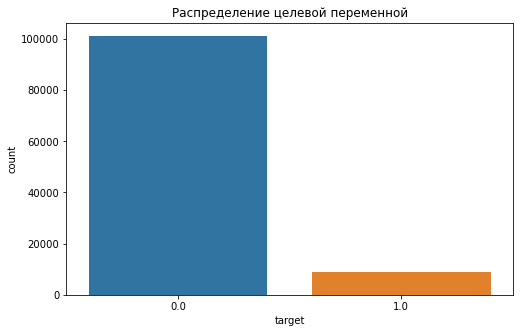

None

__Обзор номинативных признаков__

__Обзор признака «name_contract_type»__

Cash           248983
Credit Card     26251
Name: name_contract_type, dtype: int64

_Признак «name_contract_type» привели к количественным значениям_

__Обзор признака «gender»__

F      147444
M       76267
XNA         4
Name: gender, dtype: int64

_Признак «gender» привели к количественным значениям_

__Обзор признака «education_level»__

Secondary / secondary special    158887
Higher education                  54516
Incomplete higher                  7456
Lower secondary                    2736
Academic degree                     120
Name: education_level, dtype: int64

_Признак «education_level» привели к количественным значениям_

__Обзор признака «family_status»__

Married                 143149
Single / not married     32888
Civil marriage           21687
Separated                14295
Widow                    11694
Unknown                      2
Name: family_status, dtype: int64

_Признак «family_status» привели к количественным значениям_

__Обзор количественных признаков__

,table_id,application_number,target,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,total_salary_net,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
count,275234.000000,2.752340e+05,110093.000000,275234.000000,275234.000000,223715.000000,2.237150e+05,2.237150e+05,223704.000000,275234.000000,275234.00000,223715.000000,223715.000000,183605.000000,76034.000000,223715.000000,223715.000000,223713.000000,97726.000000,223236.000000,179308.000000,193517.000000,193517.000000,193517.000000,193517.000000,193517.000000,193517.000000,275234.000000,193517.000000,1.789990e+05,178999.000000,223586.000000,223586.000000,223586.000000,223586.000000,223586.000000,223704.000000,223704.000000,223715.000000,2.237040e+05,223704.000000,223715.000000,223715.000000,183604.000000,183604.000000,183593.000000,183604.000000,2.237150e+05,68685.000000,76034.000000,9.772600e+04,2.232360e+05,1.793080e+05,97718.000000,223225.000000,179298.000000
mean,137616.500000,1.235771e+08,0.080813,0.095377,0.651493,0.417978,1.689732e+05,5.991977e+05,27125.336237,0.695648,1.08278,0.020864,16031.731288,2381.686893,12.033603,0.280308,0.056728,2.154801,0.502059,0.513979,0.510665,0.006268,0.006671,0.033992,0.267093,0.266710,1.896154,1.741500,3.483637,2.686072e-01,2.049825,0.399450,0.615621,0.509036,0.512036,0.016357,21.615194,0.180981,3.958785,1.418470e+05,1.824609,39.708308,11.472905,216.599934,741.813362,34.365094,17.995911,3.768543e+03,0.015426,0.000849,3.229395e+05,3.182492e+05,3.139521e+05,14458.706591,14300.922919,13970.667374
std,79453.356333,8.877727e+04,0.272550,0.293736,0.775530,0.722796,2.697500e+05,4.018597e+05,14528.794526,0.936288,1.44753,0.013800,4360.679026,2337.014575,11.872949,0.449150,0.231323,0.911605,0.210658,0.191094,0.195224,0.083505,0.103734,0.203277,0.911643,0.853882,1.867322,2.239827,3.008580,1.487634e-01,0.635081,0.187562,0.156197,0.149938,0.157523,0.021204,7.828586,0.094603,2.690913,2.677025e+05,1.112906,28.392232,21.190829,900.341677,3060.905964,125.623721,76.005532,5.429171e+03,0.061134,0.000939,2.858115e+05,2.674723e+05,2.586578e+05,10911.603611,10251.242829,9803.815112
min,0.000000,1.234233e+08,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000000,0.00000,0.000290,7489.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014691,0.000001,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.333333,5.239158e-09,0.001592,0.000001,0.000006,0.000006,0.000006,0.000000,8.036674,0.000224,0.004808,-2.567700e+04,0.068777,1.808391,1.091880,2.232881,3.903539,0.199080,1.372097,1.918800e+01,0.000000,0.000000,2.075601e+03,2.368720e-01,2.529291e+01,145.006996,0.011844,2.375066
25%,68808.250000,1.235003e+08,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.000000,0.00000,0.010006,12412.000000,765.000000,5.000000,0.000000,0.000000,2.000000,0.333954,0.391806,0.368969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.474996e-01,1.604996,0.253963,0.539994,0.413071,0.409000,0.

__Обзор дискретных признаков__

Всего дискретных признаков: 12


__Оценка признака «amt_req_credit_bureau_qrt» в разрезе целевой переменной__

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\contingency.py:244: RuntimeWarning: invalid value encountered in less
  if np.any(observed < 0):
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


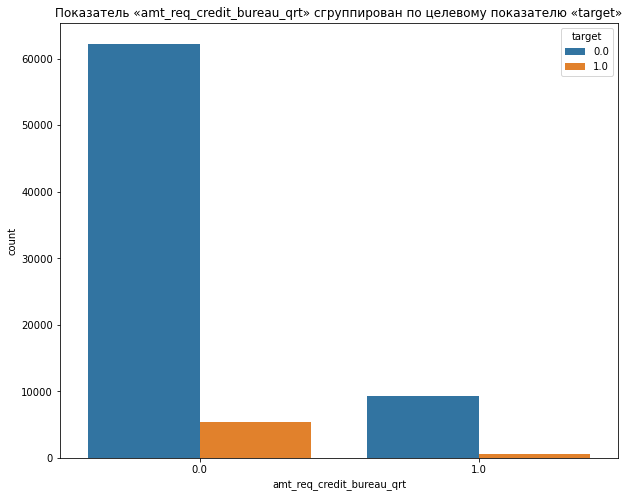

None

__Оценка признака «amt_req_credit_bureau_day» в разрезе целевой переменной__

_Признак «amt_req_credit_bureau_day» был удален, так как не влияет на целевую переменную_

__Оценка признака «gender» в разрезе целевой переменной__

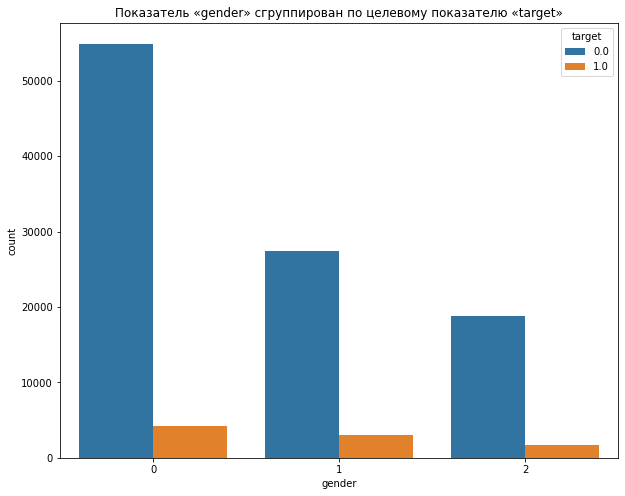

None

__Оценка признака «childrens» в разрезе целевой переменной__

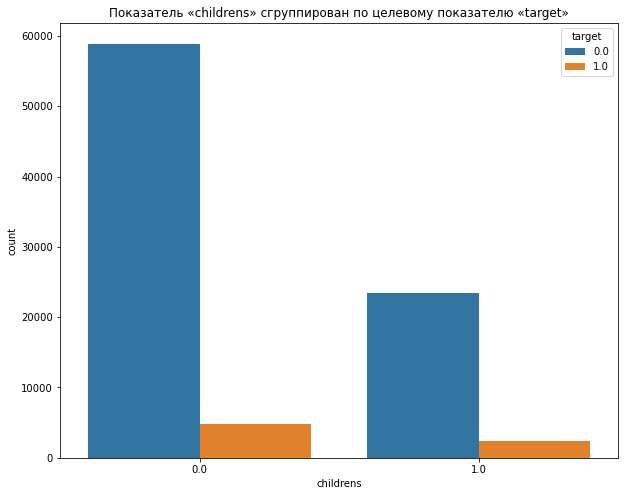

None

__Оценка признака «amt_req_credit_bureau_week» в разрезе целевой переменной__

_Признак «amt_req_credit_bureau_week» был удален, так как не влияет на целевую переменную_

__Оценка признака «education_level» в разрезе целевой переменной__

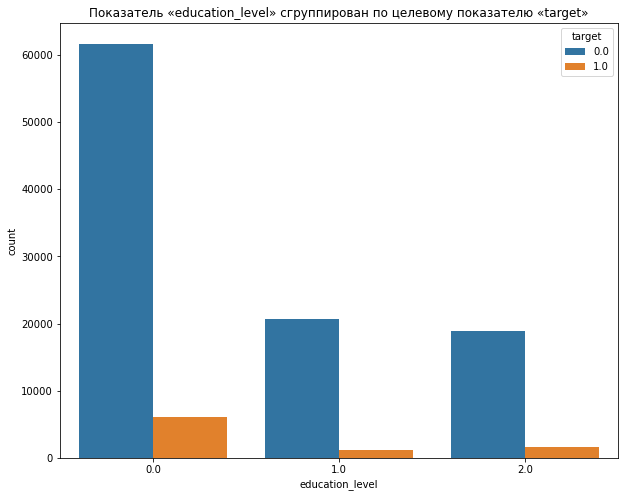

None

__Оценка признака «family_status» в разрезе целевой переменной__

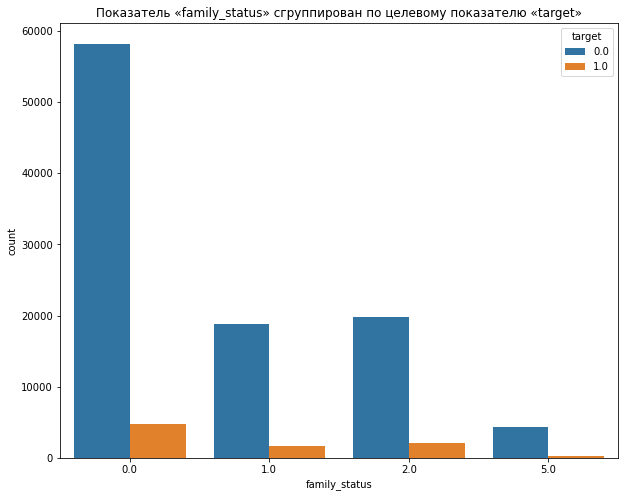

None

__Оценка признака «family_size» в разрезе целевой переменной__

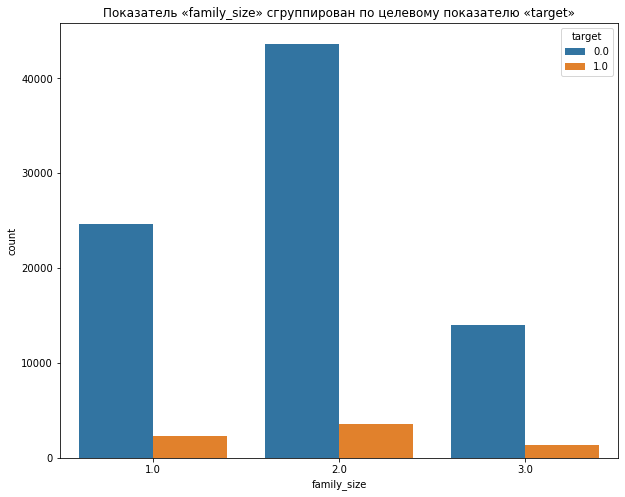

None

__Оценка признака «flag_email» в разрезе целевой переменной__

_Признак «flag_email» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_contract_type» в разрезе целевой переменной__

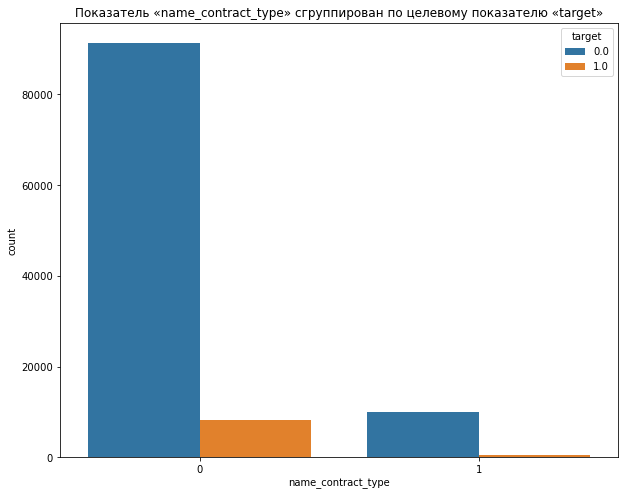

None

__Оценка признака «amt_req_credit_bureau_hour» в разрезе целевой переменной__

_Признак «amt_req_credit_bureau_hour» был удален, так как не влияет на целевую переменную_

__Оценка признака «flag_phone» в разрезе целевой переменной__

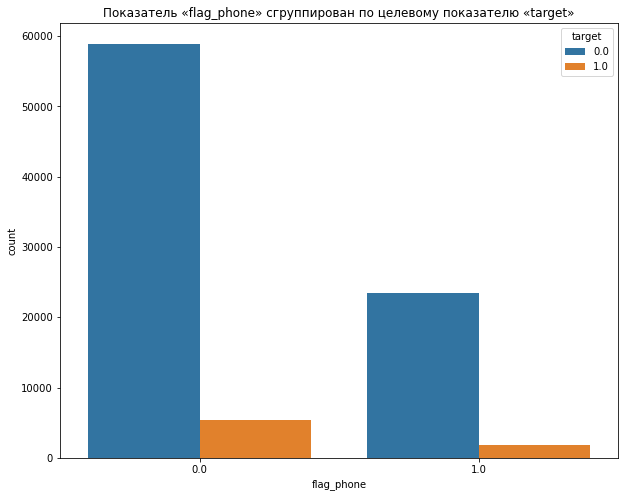

None

__Обзор непрерывных признаков__

__Оценка признака «external_scoring_rating_1» в разрезе целевой переменной__

_Привели к нормальному распределению_

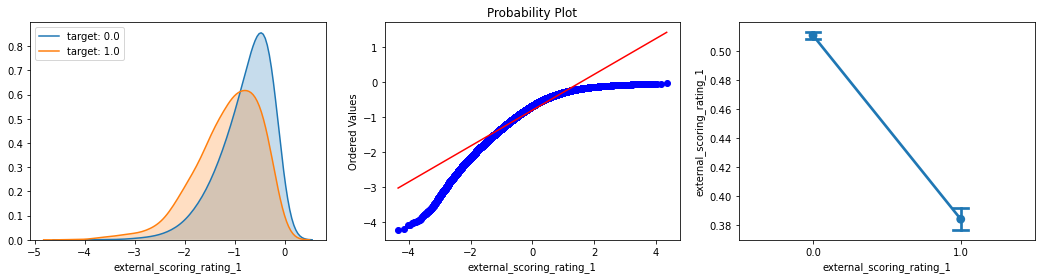

None

__Оценка признака «total_salary» в разрезе целевой переменной__

_Привели к нормальному распределению_

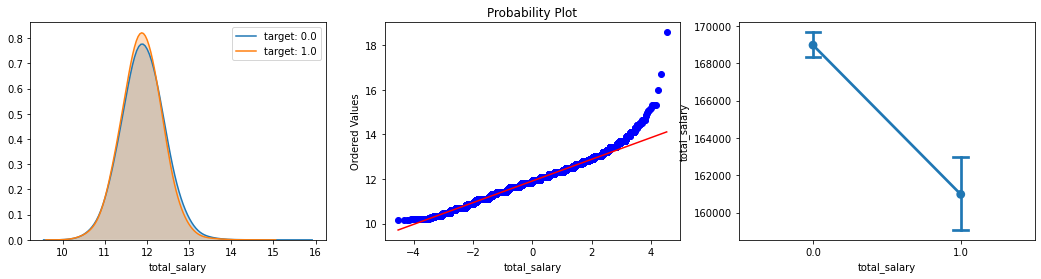

None

__Оценка признака «expected_total_loss_2» в разрезе целевой переменной__

_Привели к нормальному распределению_

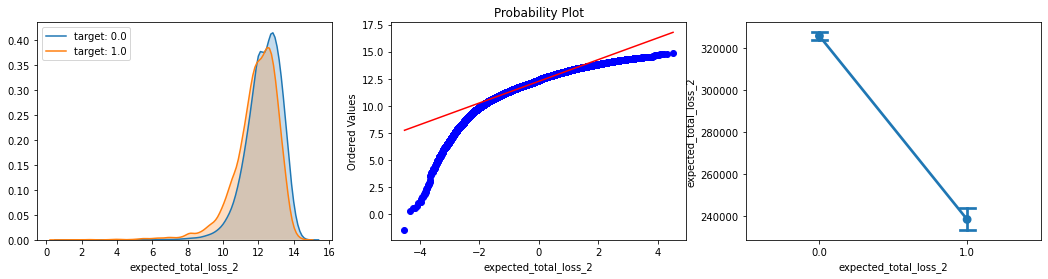

None

__Оценка признака «bki_requests_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

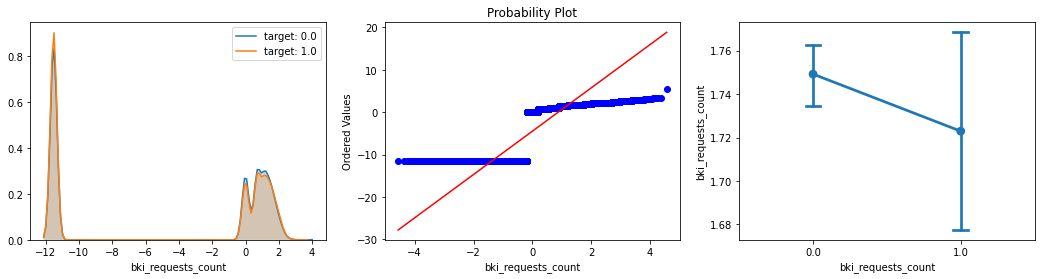

None

__Оценка признака «expected_monthly_loss_1» в разрезе целевой переменной__

_Привели к нормальному распределению_

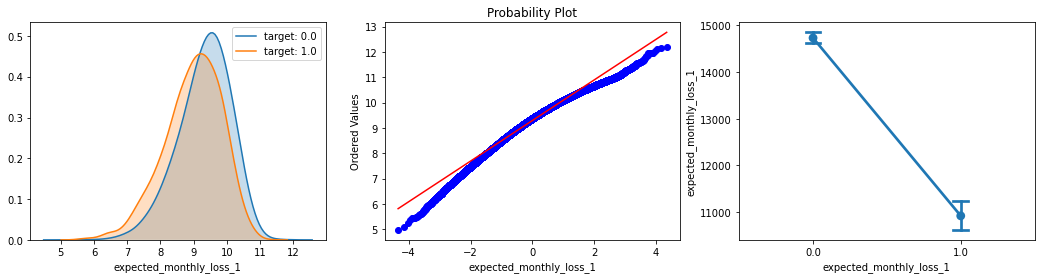

None

__Оценка признака «expected_total_loss_1» в разрезе целевой переменной__

_Привели к нормальному распределению_

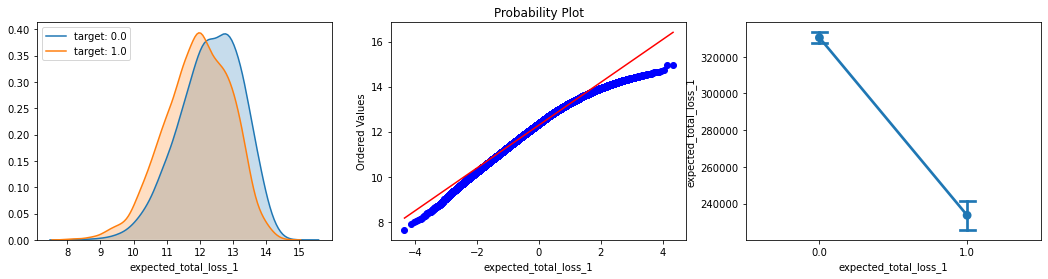

None

__Оценка признака «amount_annuity» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_annuity» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «external_scoring_rating_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

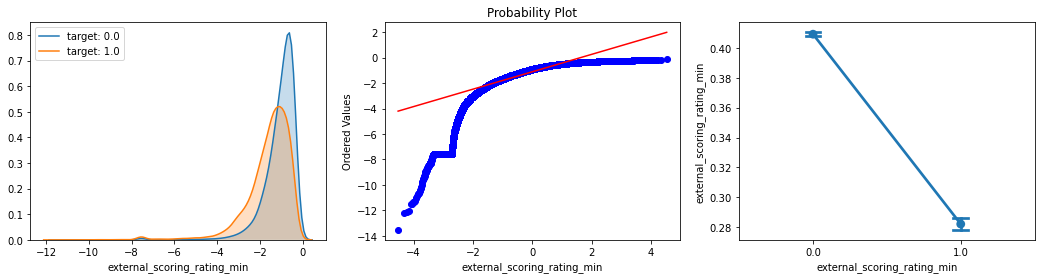

None

__Оценка признака «ratio_annuity_to_salary» в разрезе целевой переменной__

_Привели к нормальному распределению_

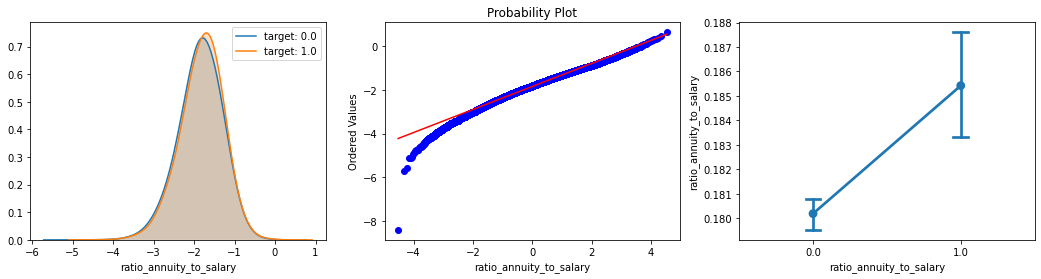

None

__Оценка признака «own_car_age» в разрезе целевой переменной__

_Привели к нормальному распределению_

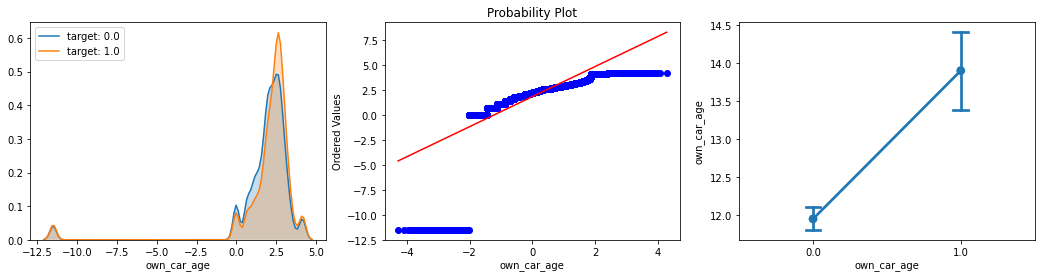

None

__Оценка признака «external_scoring_rating_2» в разрезе целевой переменной__

_Привели к нормальному распределению_

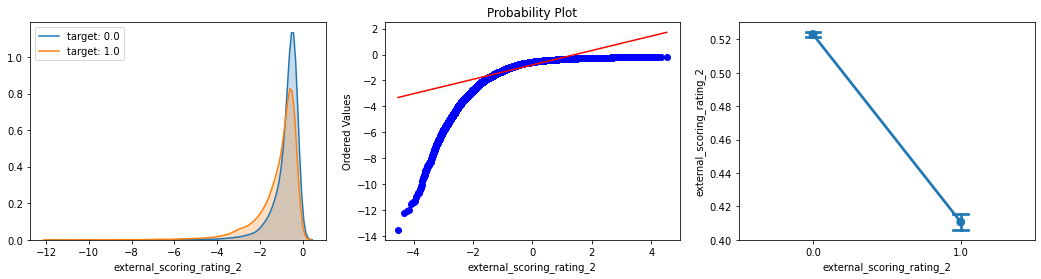

None

__Оценка признака «days_on_last_job» в разрезе целевой переменной__

_Привели к нормальному распределению_

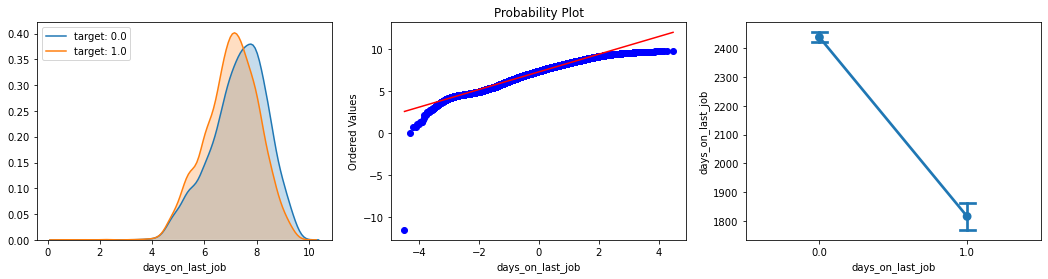

None

__Оценка признака «ratio_credit_to_experience» в разрезе целевой переменной__

_Привели к нормальному распределению_

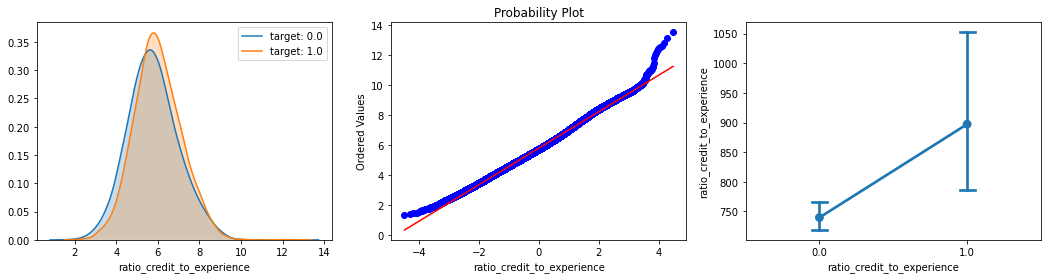

None

__Оценка признака «amt_req_credit_bureau_mon» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_req_credit_bureau_mon» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «external_scoring_rating_nanmedian» в разрезе целевой переменной__

_Привели к нормальному распределению_

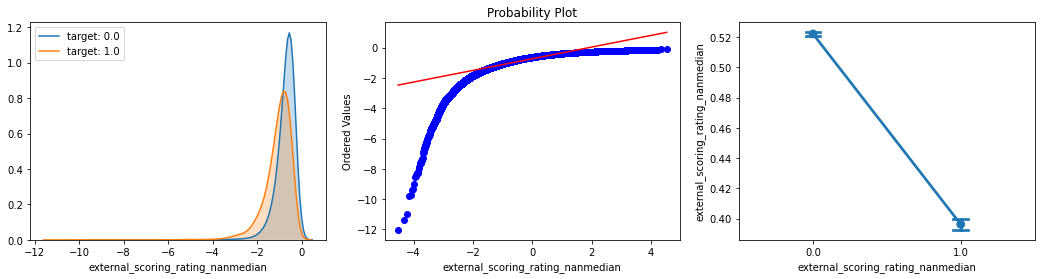

None

__Оценка признака «ratio_salary_to_age» в разрезе целевой переменной__

_Привели к нормальному распределению_

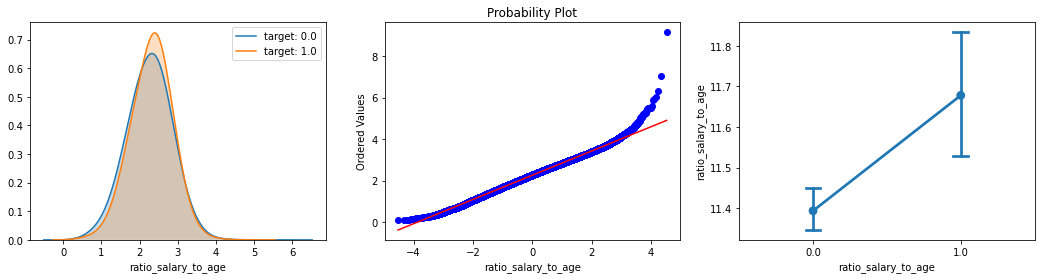

None

__Оценка признака «age» в разрезе целевой переменной__

_Привели к нормальному распределению_

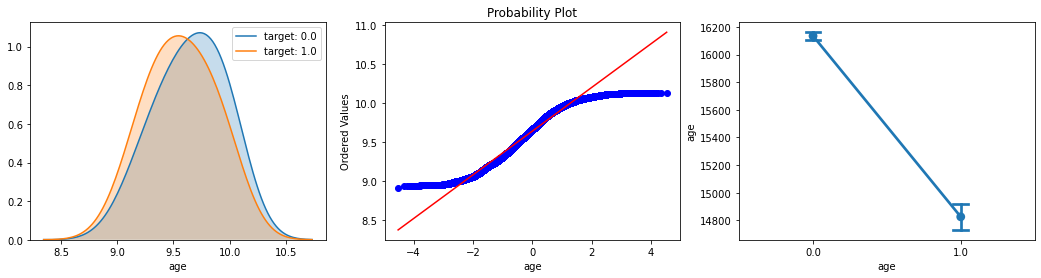

None

__Оценка признака «expected_monthly_loss_2» в разрезе целевой переменной__

_Привели к нормальному распределению_

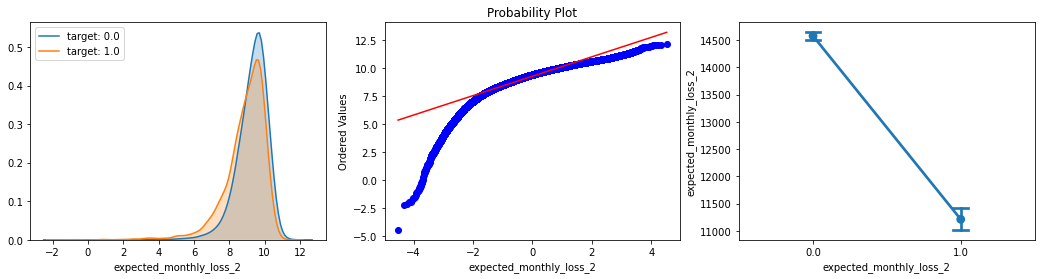

None

__Оценка признака «ratio_car_to_age» в разрезе целевой переменной__

_Привели к нормальному распределению_

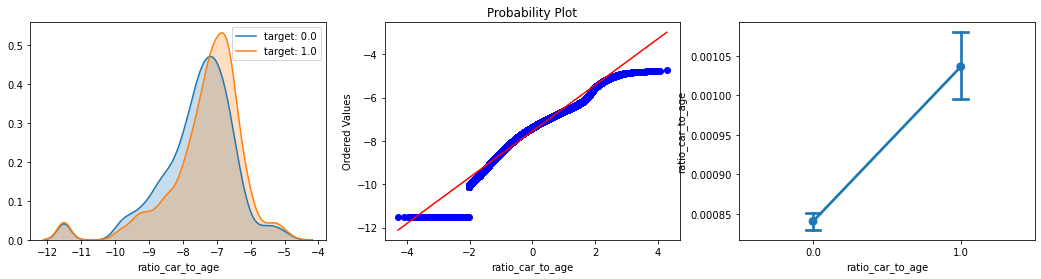

None

__Оценка признака «total_salary_net» в разрезе целевой переменной__

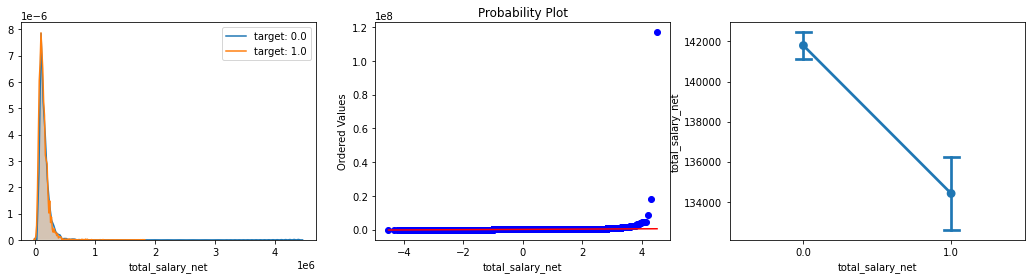

None

__Оценка признака «amt_req_credit_bureau_year» в разрезе целевой переменной__

_Привели к нормальному распределению_

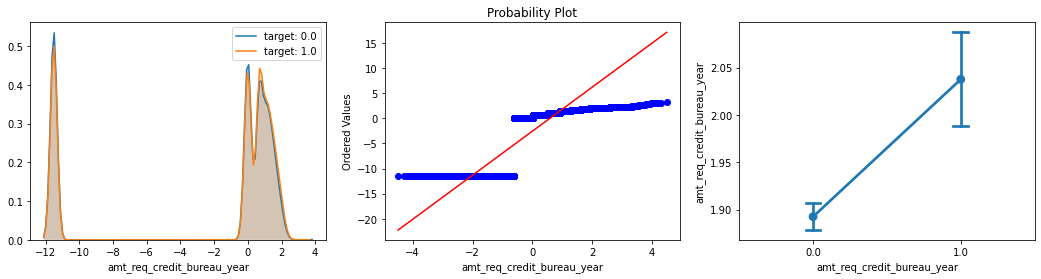

None

__Оценка признака «external_scoring_rating_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

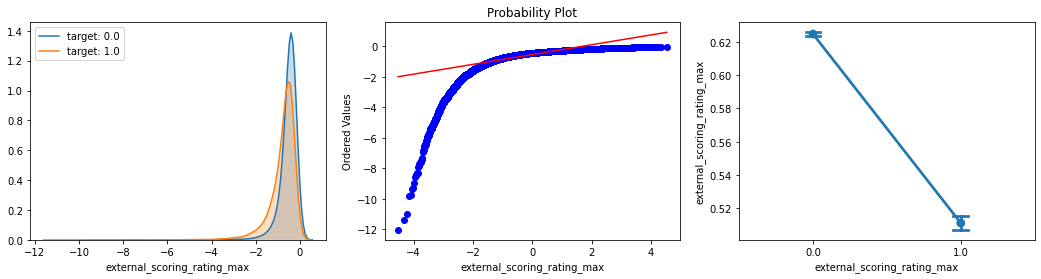

None

__Оценка признака «external_scoring_rating_3» в разрезе целевой переменной__

_Привели к нормальному распределению_

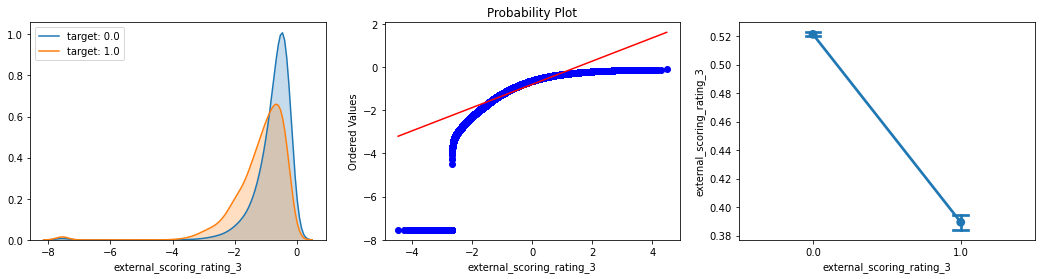

None

__Оценка признака «ratio_credit_to_annuity» в разрезе целевой переменной__

_Привели к нормальному распределению_

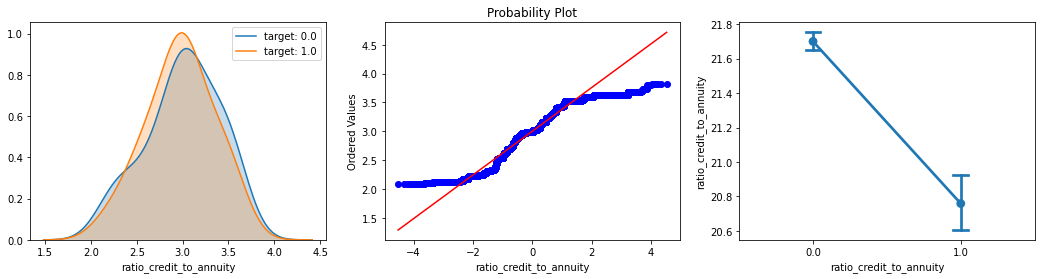

None

__Оценка признака «expected_total_loss_3» в разрезе целевой переменной__

_Привели к нормальному распределению_

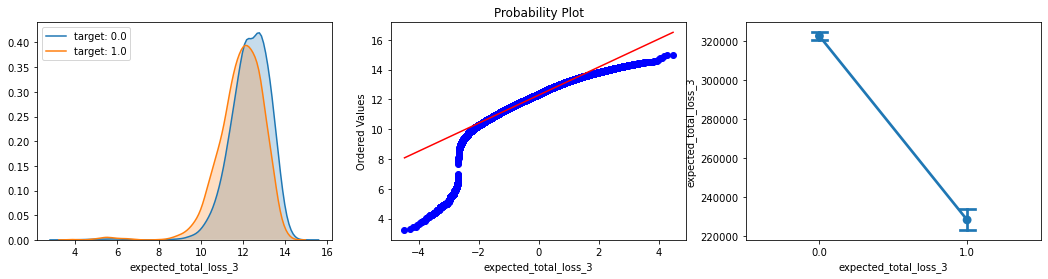

None

__Оценка признака «external_scoring_prod» в разрезе целевой переменной__

_Привели к нормальному распределению_

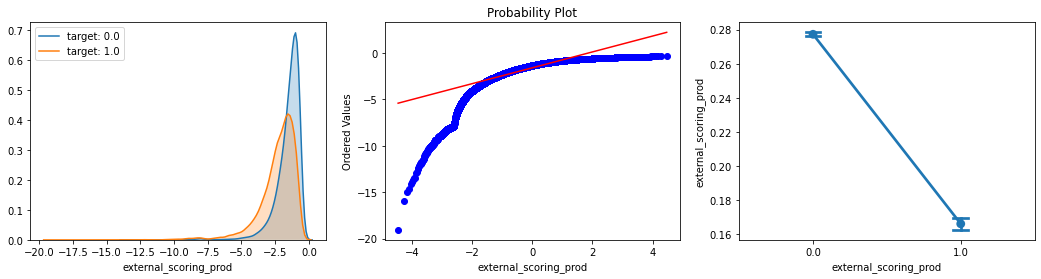

None

__Оценка признака «ratio_credit_to_age» в разрезе целевой переменной__

_Привели к нормальному распределению_

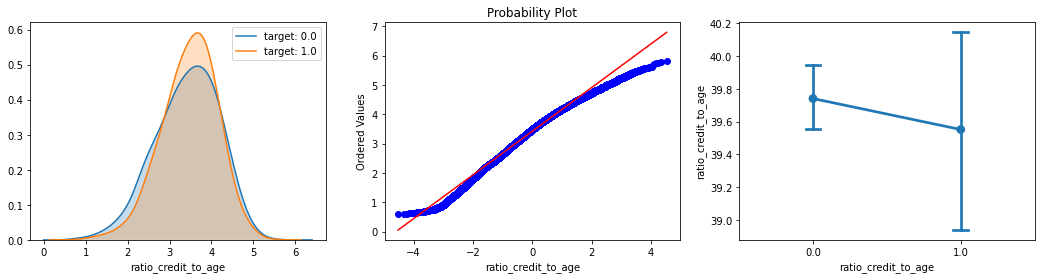

None

__Оценка признака «expected_monthly_loss_3» в разрезе целевой переменной__

_Привели к нормальному распределению_

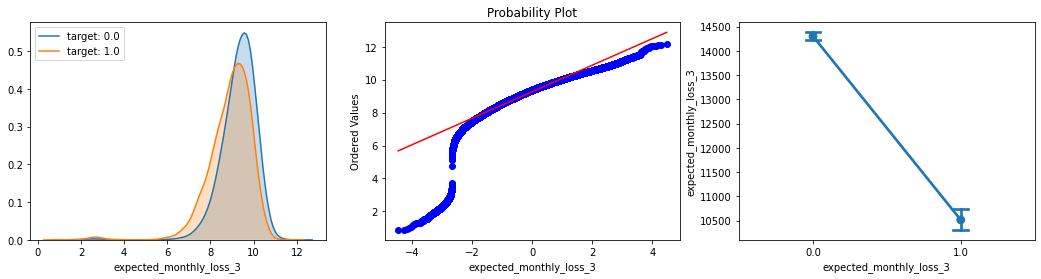

None

__Оценка признака «ratio_car_to_experience» в разрезе целевой переменной__

_Привели к нормальному распределению_

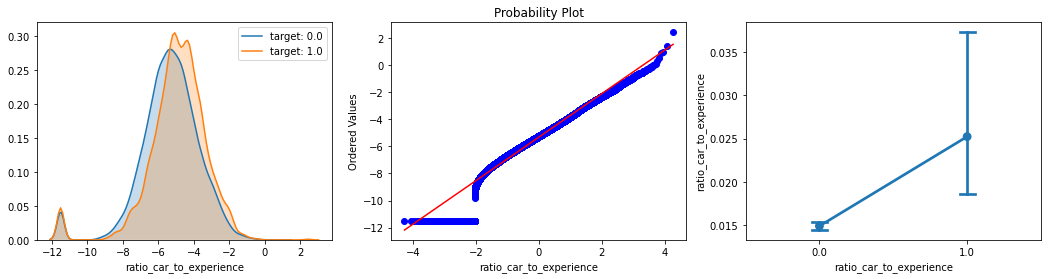

None

__Оценка признака «external_scoring_rating_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

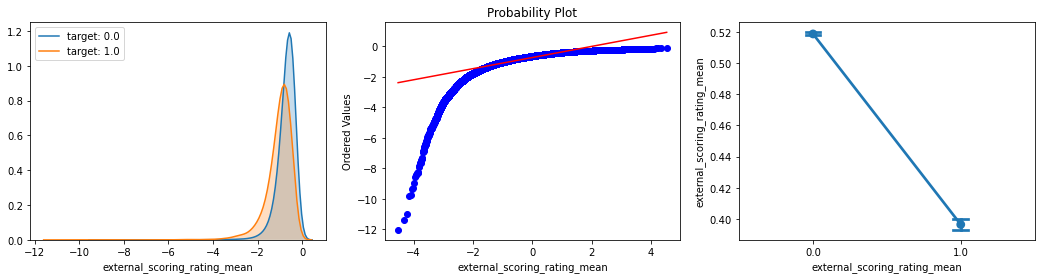

None

__Оценка признака «bki_kurtosis» в разрезе целевой переменной__

_Удаляем слобец «bki_kurtosis» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «ratio_annuity_to_age» в разрезе целевой переменной__

_Привели к нормальному распределению_

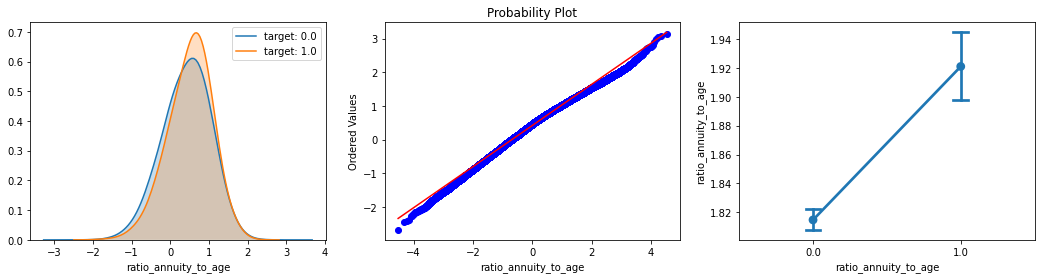

None

__Оценка признака «ratio_annuity_to_experience» в разрезе целевой переменной__

_Привели к нормальному распределению_

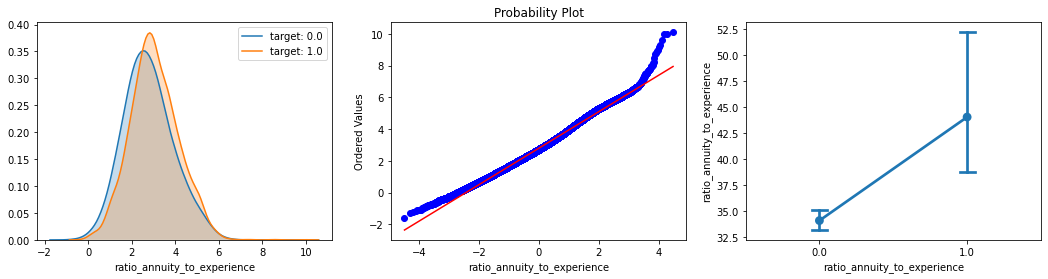

None

__Оценка признака «ratio_credit_to_salary» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «ratio_credit_to_salary» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «ratio_salary_to_region_population» в разрезе целевой переменной__

_Привели к нормальному распределению_

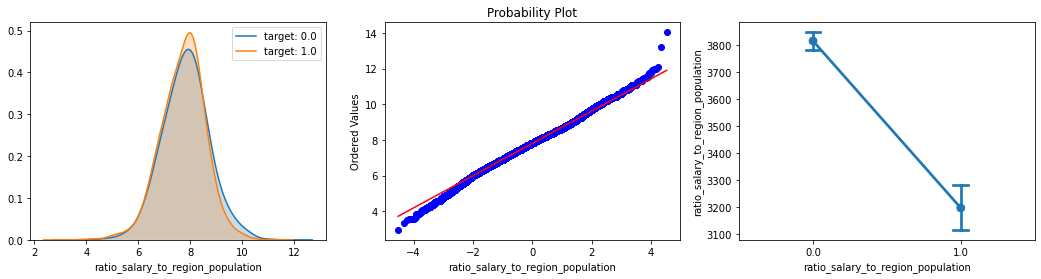

None

__Оценка признака «amount_credit» в разрезе целевой переменной__

_Привели к нормальному распределению_

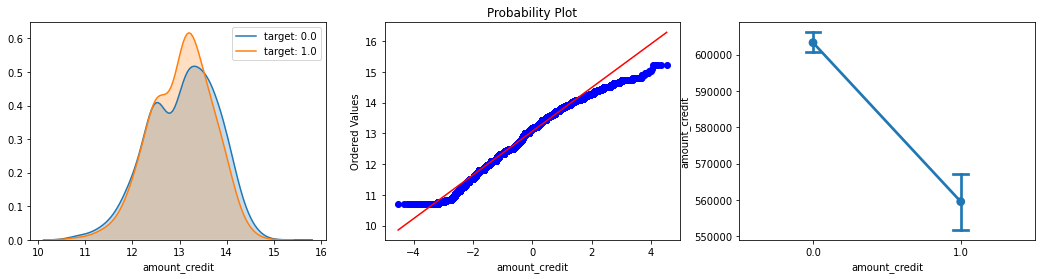

None

__Оценка признака «ratio_age_to_experience» в разрезе целевой переменной__

_Привели к нормальному распределению_

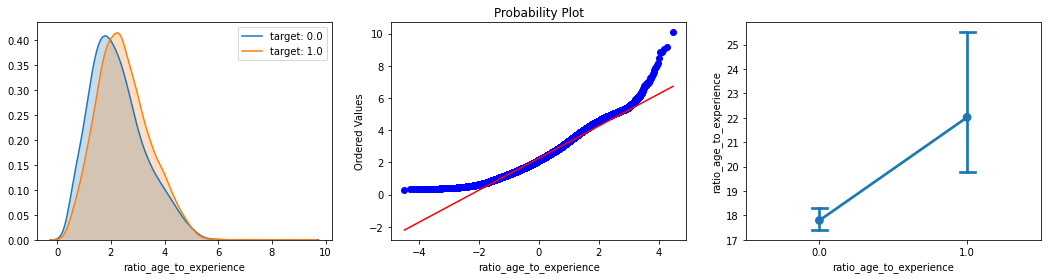

None

__Оценка признака «external_scoring_weighted» в разрезе целевой переменной__

_Привели к нормальному распределению_

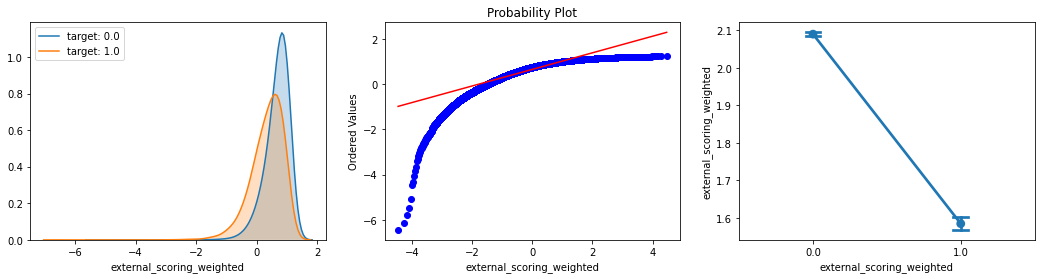

None

__Оценка признака «region_population» в разрезе целевой переменной__

_Привели к нормальному распределению_

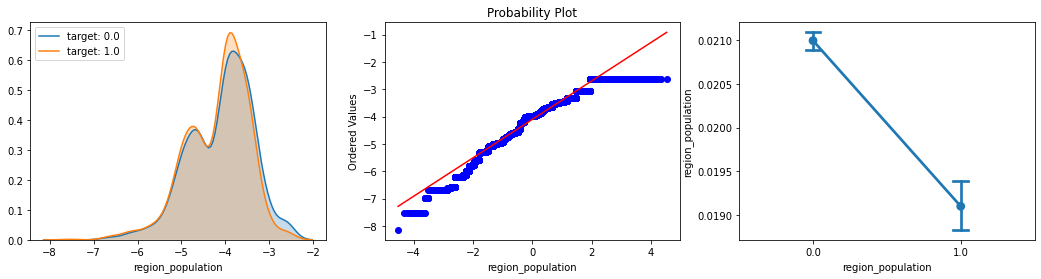

None

__Оценка признака «external_scoring_rating_var» в разрезе целевой переменной__

_Привели к нормальному распределению_

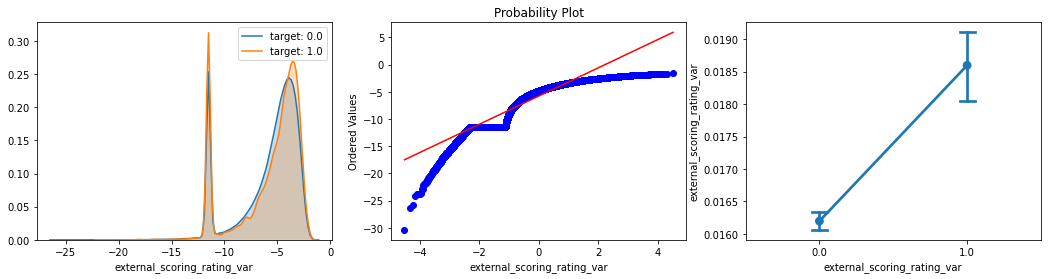

None

__Оценка признака «ratio_salary_to_experience» в разрезе целевой переменной__

_Привели к нормальному распределению_

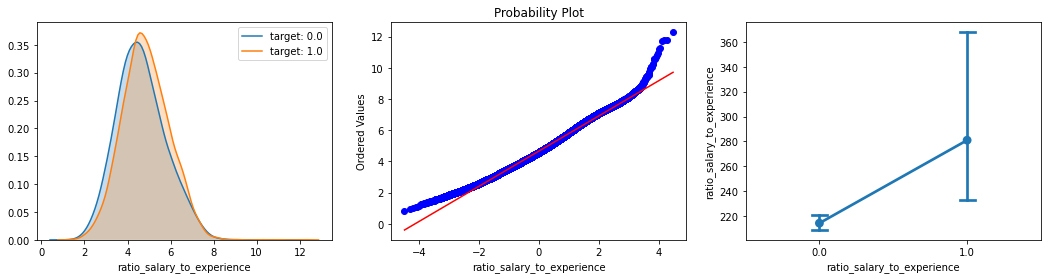

None

## Подготовка фичей

__Обработка номинативных признаков__

_Нет признаков для обработки_

__Обработка категориальных признаков__

_Обработка признака «amt_req_credit_bureau_qrt»_

_Признак «amt_req_credit_bureau_qrt» обработан_

_Обработка признака «gender»_

_Признак «gender» обработан_

_Обработка признака «childrens»_

_Признак «childrens» обработан_

_Обработка признака «education_level»_

_Признак «education_level» обработан_

_Обработка признака «family_status»_

_Признак «family_status» обработан_

_Обработка признака «family_size»_

_Признак «family_size» обработан_

_Обработка признака «name_contract_type»_

_Признак «name_contract_type» обработан_

_Обработка признака «flag_phone»_

_Признак «flag_phone» обработан_

## Анализ признакового пространства

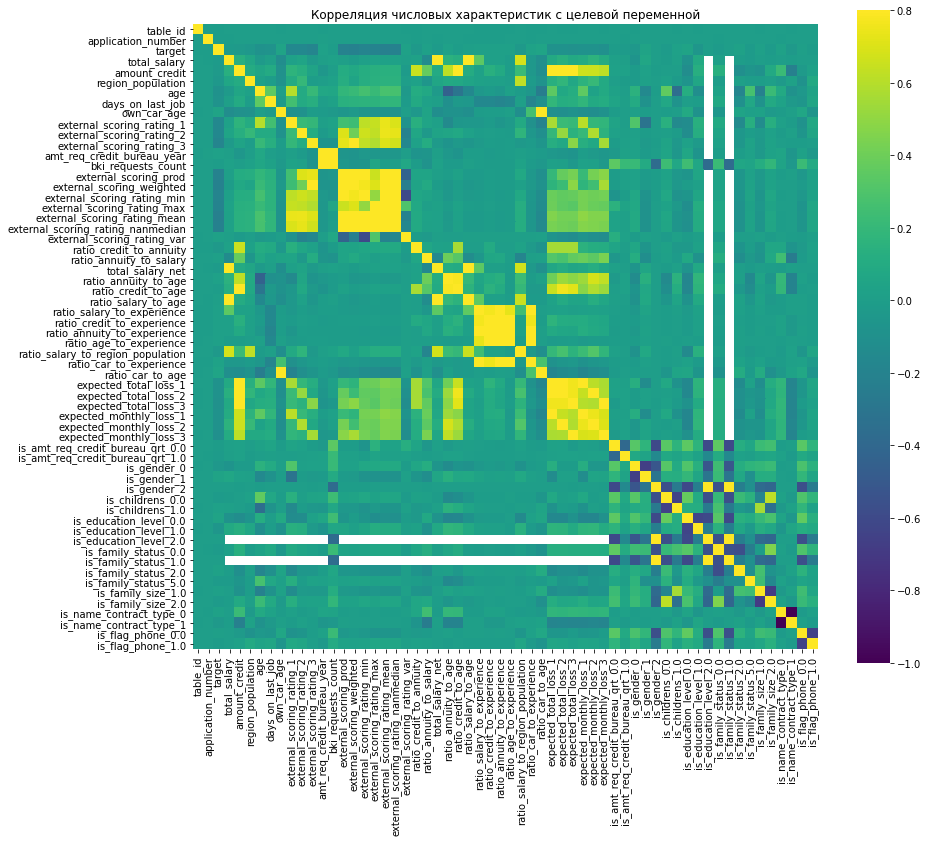

None

_Обработка признака «is_name_contract_type_1»_

_Обработка признака «is_childrens_1.0»_

_Обработка признака «external_scoring_rating_1»_

_Обработка признака «is_family_status_2.0»_

_Обработка признака «total_salary»_

_Обработка признака «expected_total_loss_2»_

_Обработка признака «bki_requests_count»_

_Обработка признака «expected_monthly_loss_1»_

_Обработка признака «expected_total_loss_1»_

_Обработка признака «ratio_annuity_to_salary»_

_Обработка признака «external_scoring_rating_min»_

_Обработка признака «ratio_credit_to_experience»_

_Обработка признака «own_car_age»_

_Обработка признака «is_amt_req_credit_bureau_qrt_0.0»_

_Обработка признака «days_on_last_job»_

_Обработка признака «external_scoring_rating_2»_

_Обработка признака «is_childrens_0.0»_

_Обработка признака «is_flag_phone_1.0»_

_Обработка признака «ratio_salary_to_age»_

_Обработка признака «expected_monthly_loss_2»_

_Обработка признака «external_scoring_rating_nanmedian»_

_Обработка признака «age»_

_Обработка признака «ratio_car_to_age»_

_Обработка признака «is_gender_1»_

_Обработка признака «total_salary_net»_

_Обработка признака «amt_req_credit_bureau_year»_

_Обработка признака «external_scoring_rating_max»_

_Обработка признака «external_scoring_rating_3»_

_Обработка признака «ratio_credit_to_annuity»_

_Обработка признака «is_amt_req_credit_bureau_qrt_1.0»_

_Обработка признака «is_flag_phone_0.0»_

_Обработка признака «expected_total_loss_3»_

_Обработка признака «is_family_status_5.0»_

_Обработка признака «is_family_size_2.0»_

_Обработка признака «is_gender_2»_

_Обработка признака «is_education_level_1.0»_

_Обработка признака «external_scoring_prod»_

_Обработка признака «ratio_credit_to_age»_

_Обработка признака «expected_monthly_loss_3»_

_Обработка признака «ratio_car_to_experience»_

_Обработка признака «is_name_contract_type_0»_

_Обработка признака «external_scoring_rating_mean»_

_Обработка признака «ratio_annuity_to_age»_

_Обработка признака «is_family_size_1.0»_

_Обработка признака «ratio_annuity_to_experience»_

_Обработка признака «ratio_salary_to_region_population»_

_Обработка признака «amount_credit»_

_Обработка признака «is_gender_0»_

_Обработка признака «is_education_level_2.0»_

_Обработка признака «is_family_status_0.0»_

_Обработка признака «ratio_age_to_experience»_

_Обработка признака «is_family_status_1.0»_

_Обработка признака «external_scoring_rating_var»_

_Обработка признака «region_population»_

_Обработка признака «ratio_salary_to_experience»_

_Обработка признака «external_scoring_weighted»_

_Обработка признака «is_education_level_0.0»_

_Признак «is_name_contract_type_1» удален_

_Признак «total_salary» удален_

_Признак «is_gender_2» удален_

_Признак «is_gender_2» удален_

## Стандартизация признакового пространства

## Отбор признаков

[09:44:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.70837	valid-auc:0.69434
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.73596	valid-auc:0.71043
[20]	train-auc:0.75149	valid-auc:0.71493
[30]	train-auc:0.76621	valid-auc:0.71733
[40]	train-auc:0.78176	valid-auc:0.72198
[50]	train-auc:0.79470	valid-auc:0.72357
[60]	train-auc:0.80334	valid-auc:0.72633
[70]	train-auc:0.81100	valid-auc:0.72690
[80]	train-auc:0.81746	valid-auc:0.72711
[90]	train-auc:0.82566	valid-auc:0.72659
Stopping. Best iteration:
[75]	train-auc:0.81433	valid-auc

100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:05<00:00, 10.24it/s]


external_scoring_rating_mean         0.060869
ratio_credit_to_annuity              0.019585
age                                  0.004449
ratio_annuity_to_experience          0.004373
is_name_contract_type_1              0.004295
external_scoring_weighted            0.004093
is_education_level_1.0               0.003528
external_scoring_rating_1            0.003207
external_scoring_rating_2            0.003099
ratio_annuity_to_salary              0.003083
external_scoring_prod                0.002239
ratio_car_to_age                     0.002061
amount_credit                        0.002015
external_scoring_rating_nanmedian    0.001770
expected_monthly_loss_2              0.001763
external_scoring_rating_max          0.001750
ratio_credit_to_age                  0.001694
expected_total_loss_2                0.001685
own_car_age                          0.001530
days_on_last_job                     0.001340
is_gender_0                          0.001320
region_population                 

_Признак «is_family_size_1.0» удален_

_Признак «is_family_status_5.0» удален_

_Признак «ratio_car_to_experience» удален_

_Признак «is_gender_2» удален_

_Признак «is_childrens_1.0» удален_

_Признак «is_family_size_2.0» удален_

_Признак «is_flag_phone_1.0» удален_

_Признак «bki_requests_count» удален_

,table_id,application_number,target,total_salary,amount_credit,region_population,age,days_on_last_job,own_car_age,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_year,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,is_amt_req_credit_bureau_qrt_0.0,is_amt_req_credit_bureau_qrt_1.0,is_gender_0,is_gender_1,is_childrens_0.0,is_education_level_0.0,is_education_level_1.0,is_family_status_0.0,is_family_status_2.0,is_name_contract_type_1,is_flag_phone_0.0
0,0,123687442,0.0,-0.042533,0.636548,-0.127740,-0.069652,-0.283562,-0.087056,0.94336,0.690423,1.054714,0.055613,1.305671,1.174341,1.314042,0.646294,1.191966,1.198230,-0.728175,1.585295,-0.226611,-0.203925,0.516105,-0.068847,-0.138811,-0.079856,-0.157194,-0.116392,-0.140010,-0.159489,0.966485,0.874885,1.154871,0.28874,0.188231,0.411607,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,123597908,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,123526683,0.0,-0.125944,1.014591,0.400582,1.267069,0.529015,NaN,NaN,0.880046,-1.243684,1.126668,-0.577298,-0.888188,-0.701536,0.425926,-0.226938,-0.235056,1.252101,0.253965,1.427215,0.138674,0.246594,-0.245882,-0.199132,-0.151428,-0.179696,-0.158379,-0.037874,NaN,NaN,1.378167,-0.170997,NaN,1.443689,-0.259428,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,3,123710391,1.0,0.040878,-0.200657,0.758329,1.446170,NaN,NaN,NaN,-1.793260,-1.742716,-1.015443,-1.609338,-2.152785,-1.220954,-2.844624,-2.255360,-2.165803,-0.771409,0.122368,-0.563998,-0.715430,-0.580934,-0.161150,NaN,NaN,NaN,NaN,0.344561,NaN,NaN,-0.857736,-0.872063,NaN,-1.011173,-1.025634,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,4,123590329,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Реализация baseline

__Обучение модели (KFold)__

Fri Nov  6 09:44:59 2020, Cross-Validation, 110093 rows, 45 cols
0:	test: 0.6503798	test1: 0.6472945	best: 0.6472945 (0)	total: 80.2ms	remaining: 2m 40s
10:	test: 0.7025354	test1: 0.6946722	best: 0.6946722 (10)	total: 257ms	remaining: 46.4s
20:	test: 0.7057927	test1: 0.6979878	best: 0.6979878 (20)	total: 443ms	remaining: 41.8s
30:	test: 0.7078751	test1: 0.6988824	best: 0.6993249 (27)	total: 631ms	remaining: 40.1s
40:	test: 0.7084447	test1: 0.6993787	best: 0.6994250 (32)	total: 829ms	remaining: 39.6s
50:	test: 0.7094840	test1: 0.7006040	best: 0.7007997 (49)	total: 1.02s	remaining: 39s
60:	test: 0.7097851	test1: 0.7014750	best: 0.7014750 (60)	total: 1.2s	remaining: 38.2s
70:	test: 0.7099243	test1: 0.7024256	best: 0.7024871 (69)	total: 1.39s	remaining: 37.9s
80:	test: 0.7111316	test1: 0.7033469	best: 0.7034270 (79)	total: 1.57s	remaining: 37.3s
90:	test: 0.7114643	test1: 0.7035632	best: 0.7037114 (89)	total: 1.76s	remaining: 36.9s
100:	test: 0.7121540	test1: 0.7044328	best: 0.7045564 (99)

920:	test: 0.7469969	test1: 0.7222437	best: 0.7222437 (920)	total: 18.2s	remaining: 21.3s
930:	test: 0.7472220	test1: 0.7222866	best: 0.7223045 (926)	total: 18.4s	remaining: 21.2s
940:	test: 0.7476274	test1: 0.7222577	best: 0.7223045 (926)	total: 18.6s	remaining: 20.9s
950:	test: 0.7478255	test1: 0.7222801	best: 0.7223045 (926)	total: 18.8s	remaining: 20.8s
960:	test: 0.7481419	test1: 0.7223064	best: 0.7223687 (957)	total: 19s	remaining: 20.6s
970:	test: 0.7484108	test1: 0.7222914	best: 0.7223687 (957)	total: 19.2s	remaining: 20.4s
980:	test: 0.7487594	test1: 0.7222595	best: 0.7223687 (957)	total: 19.4s	remaining: 20.2s
990:	test: 0.7489151	test1: 0.7222322	best: 0.7223687 (957)	total: 19.6s	remaining: 19.9s
1000:	test: 0.7491932	test1: 0.7222075	best: 0.7223687 (957)	total: 19.8s	remaining: 19.8s
1010:	test: 0.7493933	test1: 0.7222485	best: 0.7223687 (957)	total: 20s	remaining: 19.6s
1020:	test: 0.7496193	test1: 0.7223665	best: 0.7223833 (1014)	total: 20.2s	remaining: 19.4s
1030:	test

270:	test: 0.7207645	test1: 0.7173562	best: 0.7173562 (270)	total: 5.29s	remaining: 33.7s
280:	test: 0.7213305	test1: 0.7177360	best: 0.7177360 (280)	total: 5.47s	remaining: 33.5s
290:	test: 0.7220779	test1: 0.7178890	best: 0.7178890 (290)	total: 5.66s	remaining: 33.2s
300:	test: 0.7226849	test1: 0.7182290	best: 0.7183078 (299)	total: 5.85s	remaining: 33s
310:	test: 0.7231912	test1: 0.7186822	best: 0.7187960 (305)	total: 6.03s	remaining: 32.8s
320:	test: 0.7237793	test1: 0.7189716	best: 0.7190766 (318)	total: 6.23s	remaining: 32.6s
330:	test: 0.7242407	test1: 0.7192599	best: 0.7193479 (325)	total: 6.41s	remaining: 32.3s
340:	test: 0.7248743	test1: 0.7197895	best: 0.7197895 (340)	total: 6.6s	remaining: 32.1s
350:	test: 0.7253564	test1: 0.7197864	best: 0.7199404 (346)	total: 6.79s	remaining: 31.9s
360:	test: 0.7258194	test1: 0.7201867	best: 0.7202581 (359)	total: 6.97s	remaining: 31.6s
370:	test: 0.7261517	test1: 0.7202226	best: 0.7202581 (359)	total: 7.16s	remaining: 31.4s
380:	test: 0.

60:	test: 0.7084302	test1: 0.7075651	best: 0.7076541 (55)	total: 1.15s	remaining: 36.7s
70:	test: 0.7097115	test1: 0.7088170	best: 0.7090044 (66)	total: 1.34s	remaining: 36.5s
80:	test: 0.7104073	test1: 0.7093287	best: 0.7094004 (76)	total: 1.53s	remaining: 36.3s
90:	test: 0.7112444	test1: 0.7101417	best: 0.7101417 (90)	total: 1.72s	remaining: 36.1s
100:	test: 0.7118477	test1: 0.7104168	best: 0.7106503 (98)	total: 1.91s	remaining: 35.8s
110:	test: 0.7122391	test1: 0.7109924	best: 0.7110107 (104)	total: 2.1s	remaining: 35.7s
120:	test: 0.7126381	test1: 0.7114681	best: 0.7115526 (119)	total: 2.29s	remaining: 35.5s
130:	test: 0.7128052	test1: 0.7120797	best: 0.7121781 (128)	total: 2.47s	remaining: 35.3s
140:	test: 0.7133433	test1: 0.7122348	best: 0.7122348 (140)	total: 2.66s	remaining: 35.1s
150:	test: 0.7139042	test1: 0.7128077	best: 0.7128077 (150)	total: 2.85s	remaining: 34.9s
160:	test: 0.7141859	test1: 0.7127820	best: 0.7129053 (153)	total: 3.04s	remaining: 34.7s
170:	test: 0.7147727

980:	test: 0.7457359	test1: 0.7299518	best: 0.7299574 (977)	total: 19.2s	remaining: 19.9s
990:	test: 0.7459273	test1: 0.7300139	best: 0.7300139 (990)	total: 19.4s	remaining: 19.7s
1000:	test: 0.7462133	test1: 0.7300630	best: 0.7301381 (997)	total: 19.6s	remaining: 19.5s
1010:	test: 0.7465525	test1: 0.7300576	best: 0.7301381 (997)	total: 19.8s	remaining: 19.4s
1020:	test: 0.7468833	test1: 0.7302202	best: 0.7302391 (1019)	total: 20s	remaining: 19.2s
1030:	test: 0.7470901	test1: 0.7303201	best: 0.7303403 (1021)	total: 20.2s	remaining: 19s
1040:	test: 0.7472854	test1: 0.7304216	best: 0.7304401 (1031)	total: 20.4s	remaining: 18.8s
1050:	test: 0.7475740	test1: 0.7303360	best: 0.7304401 (1031)	total: 20.6s	remaining: 18.6s
1060:	test: 0.7477668	test1: 0.7303533	best: 0.7304884 (1056)	total: 20.8s	remaining: 18.4s
1070:	test: 0.7480047	test1: 0.7303687	best: 0.7304884 (1056)	total: 20.9s	remaining: 18.2s
1080:	test: 0.7481274	test1: 0.7307236	best: 0.7307355 (1076)	total: 21.1s	remaining: 18s


340:	test: 0.7258119	test1: 0.7125586	best: 0.7126590 (335)	total: 6.5s	remaining: 31.6s
350:	test: 0.7262205	test1: 0.7127395	best: 0.7127637 (349)	total: 6.74s	remaining: 31.7s
360:	test: 0.7267070	test1: 0.7131562	best: 0.7132711 (358)	total: 6.92s	remaining: 31.4s
370:	test: 0.7271234	test1: 0.7135447	best: 0.7135702 (368)	total: 7.11s	remaining: 31.2s
380:	test: 0.7276023	test1: 0.7137556	best: 0.7138046 (377)	total: 7.3s	remaining: 31s
390:	test: 0.7279625	test1: 0.7139726	best: 0.7139883 (388)	total: 7.49s	remaining: 30.8s
400:	test: 0.7284829	test1: 0.7141818	best: 0.7141818 (400)	total: 7.69s	remaining: 30.6s
410:	test: 0.7290367	test1: 0.7145266	best: 0.7146110 (409)	total: 7.88s	remaining: 30.5s
420:	test: 0.7294503	test1: 0.7150839	best: 0.7150839 (420)	total: 8.07s	remaining: 30.3s
430:	test: 0.7297866	test1: 0.7151296	best: 0.7151368 (427)	total: 8.25s	remaining: 30s
440:	test: 0.7302893	test1: 0.7152824	best: 0.7153437 (438)	total: 8.44s	remaining: 29.8s
450:	test: 0.730

Fold 4, Valid score = 0.72106, probability threshold: 0.08800000000000001, probability score: 0.6529931733948672
0:	test: 0.6498214	test1: 0.6567685	best: 0.6567685 (0)	total: 17.9ms	remaining: 35.7s
10:	test: 0.7006699	test1: 0.6993186	best: 0.6993186 (10)	total: 205ms	remaining: 37.1s
20:	test: 0.7041486	test1: 0.7016987	best: 0.7016987 (20)	total: 385ms	remaining: 36.3s
30:	test: 0.7058812	test1: 0.7024845	best: 0.7025253 (24)	total: 571ms	remaining: 36.2s
40:	test: 0.7072473	test1: 0.7040904	best: 0.7044755 (35)	total: 751ms	remaining: 35.9s
50:	test: 0.7077724	test1: 0.7055996	best: 0.7058166 (49)	total: 938ms	remaining: 35.8s
60:	test: 0.7081670	test1: 0.7060536	best: 0.7062672 (59)	total: 1.11s	remaining: 35.3s
70:	test: 0.7089143	test1: 0.7065173	best: 0.7065727 (64)	total: 1.3s	remaining: 35.3s
80:	test: 0.7097613	test1: 0.7074146	best: 0.7074146 (80)	total: 1.48s	remaining: 35.2s
90:	test: 0.7102468	test1: 0.7079984	best: 0.7080755 (86)	total: 1.67s	remaining: 35.1s
100:	test

910:	test: 0.7440517	test1: 0.7252909	best: 0.7253674 (847)	total: 17.5s	remaining: 20.9s
920:	test: 0.7441922	test1: 0.7254170	best: 0.7254242 (919)	total: 17.7s	remaining: 20.7s
930:	test: 0.7444600	test1: 0.7254634	best: 0.7255060 (926)	total: 17.9s	remaining: 20.5s
940:	test: 0.7446576	test1: 0.7256084	best: 0.7256084 (940)	total: 18.1s	remaining: 20.3s
950:	test: 0.7449564	test1: 0.7256625	best: 0.7256779 (947)	total: 18.3s	remaining: 20.1s
960:	test: 0.7451991	test1: 0.7257615	best: 0.7258394 (959)	total: 18.5s	remaining: 19.9s
970:	test: 0.7454847	test1: 0.7259806	best: 0.7260227 (969)	total: 18.6s	remaining: 19.7s
980:	test: 0.7457093	test1: 0.7259618	best: 0.7260514 (971)	total: 18.8s	remaining: 19.5s
990:	test: 0.7460273	test1: 0.7259462	best: 0.7260681 (988)	total: 19s	remaining: 19.3s
1000:	test: 0.7462446	test1: 0.7260326	best: 0.7260681 (988)	total: 19.2s	remaining: 19.1s
1010:	test: 0.7465087	test1: 0.7261444	best: 0.7261476 (1009)	total: 19.4s	remaining: 19s
1020:	test:

__Подготовка прогноза__

__Сохранение результата__

,APPLICATION_NUMBER,TARGET
110093,123724268,0.061599
110094,123456549,0.232087
110095,123428178,0.168259
110096,123619984,0.084431
110097,123671104,0.019641
...,...,...
275229,123487967,0.084431
275230,123536402,0.046256
275231,123718238,0.084431
275232,123631557,0.019424


Сохранено: geekbrains-competitive-data-analysis/baseline_submit.csv


In [49]:
entry(create_client_profile_features,
      'baseline_submit.csv', 
      'test.csv', 
      'train.csv', 
      'client_profile.csv',
#       'bki.csv',
#       'payments.csv',
#       'applications_history.csv'
     )

__Выводы:__
    1. При разных запусках при одних и тех же параметрах точность скачет в полпроцента. Надо несколько раз запустить, чтобы получить лучший результат. Добился стабильной работы алгоритма с погрешностью в 4-м знаке.
    2. Если отключить предварительную обработку данных, то точность опять же увеличится в 0.3 %, что вобщем-то и понятно (результат в лидерборде). Тут два варианта почему: первый - данные уже были предварительно подготовлены и второй - в физическом эксперименте, если мы как-то меняем данные, то наша средняя начинает "уходить" от истинного значения.
    3. В целом алгоритм работает стабильно и с любыми данными (проверено), подкруткой параметров, которые вынесены в отдельную ячейку можно добиться неплохой точности.
    4. Не все графики удалось вывести.
    5. Базовые настройки, со всем включенными значениями по умолчанию дают значение скора OOF-score = 0.7233±0.0003.
    6. Самый точный метод KFold, он дает наибольшее значение скора.
    7. Таблицы 'bki.csv', 'payments.csv', 'applications_history.csv' какого либо существенного вклада не вносят.
    8. Отказ от обработки пропусков добавил 0,002.
    9. Отказ от обработки выбросов добавил 0,001.
    10. Отключение остальных функций ведет либо к незначительному падению значений скора, либо никак не влияет на его изменения.
    11. Самые значимые фичи "external_scoring_rating_mean" и "ratio_credit_to_annuity", только с их участием скор дает значение OOF-score = 0.70382.

__TODO:__
    1. Отрефакторить (есть местами код, который "дурно пахнет").
    2. Выбор модели реализовать через фабричный метод.
    3. Перенести код в отдельный модуль и адаптировать запуск вне зависимости от среды исполнения и так, чтобы можно было запускать алгоритм на проде.
    4. Архитектуру переписать на классы.
    5. Для унификации и возможности вывода графиков и прочего использовать поведенческий паттерн проектирования "Strategy" (если мы работаем с консолью Jupiter, то выводить красивые графики, в противном случае не выводить)
    6. Реализовать выполнение пользовательских функций обработки данных по типу функции create_client_profile_features с использованием паттерна "Observer".
    7. Для сохранения наилучших моделей и параметров их настроек использовать паттерн проектирования "Memento"
    8. Для гибкой работы алгоритма с различными типами моделей использовать паттерны проектирования "Chain of Command", "Template Method" и "State".
    9. Подключить другие модели помимо catboost.
    10. Реализовать "ансамблирование моделей", пока не получилось.
    11. Сделать прогонку основного алготима до 10 раз (задавать через параметры) и выбор наилучшего результата и модели.
    12. Сделать автоподбор параметров запуска, алгоритм будет работать существенно дольше, но это позволит более точно подобрать параметры с наиболее лучшим результатом.
    13. Сделать множественную классификацию.
    14. Сделать кластеризацию.
    15. Сделать регрессию.
    16. Дополнить алгоритм классическими методами аппроксимации.
    17. Написать веб-морду.